## Regression and Classification with the Ames Housing Data

---
This code uses the [Ames housing data available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

## 1. Estimating the value of homes from fixed characteristics.

---

The full description of the data features can be found in a separate file:

    housing.csv
    
### The task is to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated.



In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Load the data
house = pd.read_csv('housing.csv')

In [3]:
house.T.head(5)

0     1      2     3      4      5      6      7     8     9     \
Id              1     2      3     4      5      6      7      8     9    10   
MSSubClass     60    20     60    70     60     50     20     60    50   190   
MSZoning       RL    RL     RL    RL     RL     RL     RL     RL    RM    RL   
LotFrontage    65    80     68    60     84     85     75    NaN    51    50   
LotArea      8450  9600  11250  9550  14260  14115  10084  10382  6120  7420   

             ...  1450  1451  1452   1453  1454  1455   1456  1457  1458  1459  
Id           ...  1451  1452  1453   1454  1455  1456   1457  1458  1459  1460  
MSSubClass   ...    90    20   180     20    20    60     20    70    20    20  
MSZoning     ...    RL    RL    RM     RL    FV    RL     RL    RL    RL    RL  
LotFrontage  ...    60    78    35     90    62    62     85    66    68    75  
LotArea      ...  9000  9262  3675  17217  7500  7917  13175  9042  9717  9937  

[5 rows x 1460 columns]

### Modify column names to make them more meaningful

In [4]:
name_change_dict = {'MSSubClass': 'BuildingClass',
                    'MSZoning': 'ZoneClassification',
                    'LotFrontage':'FrontStreetFeet',
                    'LotArea': 'LandArea',
                    'Condition1':'ProxiToRoadRail1',
                    'Condition2': 'ProxiToRoadRail2',
                    'Exterior1st':'ExteriorCover1',
                    'Exterior2nd': 'ExteriorCover2',
                    'BsmtQual': 'BsmtHeight',
                    'BsmtFinSF1':'BsmtFinArea1',
                    'BsmtFinSF2': 'BsmtFinArea2',
                    'BsmtUnfSF': 'BsmtUnfinishArea',
                    '1stFlrSF': '1stFlrArea',
                    '2ndFlrSF': '2ndFlrArea',
                    'LowQualFinSF': 'LowQualFinArea',
                    'GrLivArea':'AboveGradeLiveArea',
                    'TotRmsAbvGrd': 'RoomsAboveGrade',
                    'WoodDeckSF': 'WoodDeckArea',
                    'OpenPorchSF': 'OpenPorchArea',
                    'EnclosedPorch': 'EnclosedPorchArea',
                    '3SsnPorch': '3SeasonPorchArea',
                    'ScreenPorch': 'ScreenPorchArea',
                    'Fence':'FenceQual'}

In [5]:
house = house.rename(columns = name_change_dict)

### Remove non-residential houses

In [6]:
# RH	Residential High Density
#        RL	Residential Low Density
#        RP	Residential Low Density Park 
#        RM	Residential Medium Density
house['ZoneClassification'].unique()

residential_classification = ['RH', 'RL', 'RP', 'RM']

house = house[house['ZoneClassification'].isin(residential_classification)]

In [7]:
house.head(3)

Id  BuildingClass ZoneClassification  FrontStreetFeet  LandArea Street  \
0   1             60                 RL             65.0      8450   Pave   
1   2             20                 RL             80.0      9600   Pave   
2   3             60                 RL             68.0     11250   Pave   

  Alley LotShape LandContour Utilities  ... PoolArea PoolQC FenceQual  \
0   NaN      Reg         Lvl    AllPub  ...        0    NaN       NaN   
1   NaN      Reg         Lvl    AllPub  ...        0    NaN       NaN   
2   NaN      IR1         Lvl    AllPub  ...        0    NaN       NaN   

  MiscFeature MiscVal MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         NaN       0      2   2008        WD         Normal     208500  
1         NaN       0      5   2007        WD         Normal     181500  
2         NaN       0      9   2008        WD         Normal     223500  

[3 rows x 81 columns]

In [8]:
house.YrSold.unique()

array([2008, 2007, 2006, 2009, 2010])

### This  section cleans null values

#### Null value strategy

- FrontStreetFeet: 251 null values, propose to replace those with median values.
- Alley: 1320 null values, replace as 'NA', since nan actually means no alley access
- BsmtHeight: 37 null values, nan means no basement, replace as 'NA'.
- GarageYrBlt: 79 null values, assume garage is built at same year as house, replace as house year.

#### FrontStreetFeet na

In [9]:
house.FrontStreetFeet.unique()

array([ 65.,  80.,  68.,  60.,  84.,  85.,  75.,  nan,  51.,  50.,  70.,
        91.,  72.,  66., 101.,  57.,  44., 110.,  98.,  47., 108., 112.,
        74., 115.,  61.,  48.,  33.,  52., 100.,  89.,  63.,  76.,  81.,
        95.,  69.,  21.,  32.,  78., 121., 122.,  73.,  77.,  64.,  94.,
       105.,  90.,  55.,  88.,  82.,  71.,  24., 120., 107.,  92., 134.,
        40.,  62.,  86., 141.,  97.,  54.,  41.,  79., 174.,  99.,  67.,
        83.,  43., 103.,  93.,  30., 129., 140.,  34.,  37., 118.,  87.,
       116., 150., 111.,  49.,  96.,  59.,  36.,  56.,  58.,  38., 109.,
       130.,  53., 137.,  35.,  45., 106., 104.,  42.,  39., 144., 114.,
       102., 128., 149., 313., 168., 182., 138., 160., 152., 124., 153.,
        46.])

In [10]:
house['FrontStreetFeet'].fillna(house['FrontStreetFeet'].median(), inplace = True)

#### Alley

In [11]:
house['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [12]:
house['Alley'].fillna('Not Available', inplace = True)

#### Basement height na

In [13]:
house['BsmtHeight'].fillna('Not Available', inplace = True)

In [14]:
#house['GarageYrBlt'].fillna(house['YearBuilt'], inplace = True)

#### BsmtCond, basement condition fix nan

In [15]:
house['BsmtCond'].unique()

array(['TA', 'Gd', nan, 'Fa', 'Po'], dtype=object)

In [16]:
house['BsmtCond'].fillna('Not Available', inplace = True)

#### BsmtExposure, fix nan

In [17]:
house['BsmtExposure'].unique()

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

In [18]:
house['BsmtExposure'].fillna('Not Available', inplace = True)

#### BsmtFinType1, fix nan

In [19]:
house['BsmtFinType1'].fillna('Not Available', inplace = True)

#### BsmtFinType2, fix nan

In [20]:
house['BsmtFinType2'].unique()

array(['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object)

In [21]:
house[house['BsmtFinType2'].isnull()][['BsmtFinType2','BsmtHeight', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1']].head()

BsmtFinType2     BsmtHeight       BsmtCond   BsmtExposure   BsmtFinType1
17           NaN  Not Available  Not Available  Not Available  Not Available
39           NaN  Not Available  Not Available  Not Available  Not Available
90           NaN  Not Available  Not Available  Not Available  Not Available
102          NaN  Not Available  Not Available  Not Available  Not Available
156          NaN  Not Available  Not Available  Not Available  Not Available

In [22]:
house['BsmtFinType2'].fillna('Not Available', inplace = True)

#### MasVnrType, fix nan

In [23]:
house['MasVnrType'].fillna('Not Available', inplace = True)

#### MasVnrArea, fix nan

In [24]:
house[house['MasVnrArea'].isnull()][['MasVnrType', 'MasVnrArea']]

MasVnrType  MasVnrArea
234   Not Available         NaN
529   Not Available         NaN
936   Not Available         NaN
1243  Not Available         NaN
1278  Not Available         NaN

In [25]:
house['MasVnrArea'].fillna(0, inplace = True)

#### Electrical, fix nan

In [26]:
house['Electrical'].unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object)

In [27]:
house['Electrical'].fillna('Not Available', inplace = True)

#### FireplaceQu , fix nan

In [28]:
house['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [29]:
house[house['FireplaceQu'].isnull()][['Fireplaces', 'FireplaceQu']]

Fireplaces FireplaceQu
0              0         NaN
5              0         NaN
10             0         NaN
12             0         NaN
15             0         NaN
17             0         NaN
18             0         NaN
19             0         NaN
26             0         NaN
29             0         NaN
31             0         NaN
32             0         NaN
36             0         NaN
38             0         NaN
39             0         NaN
42             0         NaN
43             0         NaN
44             0         NaN
48             0         NaN
49             0         NaN
50             0         NaN
52             0         NaN
57             0         NaN
59             0         NaN
60             0         NaN
61             0         NaN
63             0         NaN
64             0         NaN
67             0         NaN
68             0         NaN
...          ...         ...
1390           0         NaN
1391           0         NaN
1397           0         NaN
1398           0         NaN
1403           0         NaN
1404           0         NaN
1406           0         NaN
1407           0         NaN
1408           0         NaN
1410           0         NaN
1411           0         NaN
1412           0         NaN
1416           0         NaN
1418           0         NaN
1422           0         NaN
1425           0         NaN
1431           0         NaN
1432           0         NaN
1436           0         NaN
1438           0         NaN
1444           0         NaN
1445           0         NaN
1446           0         NaN
1448           0         NaN
1449           0         NaN
1450           0         NaN
1452           0         NaN
1453           0         NaN
1458           0         NaN
1459           0         NaN

[641 rows x 2 columns]

In [30]:
house['FireplaceQu'].fillna('Not Available', inplace = True)

#### Garage year built

In [31]:
house['GarageYrBlt'].dtypes

dtype('float64')

#### GarageType, fix nan

In [32]:
house['GarageType'].unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types'],
      dtype=object)

In [33]:
house[house['GarageYrBlt'].isnull()][['GarageYrBlt', 'GarageType', 'GarageFinish','GarageQual', 'GarageCond']].head()

GarageYrBlt GarageType GarageFinish GarageQual GarageCond
39          NaN        NaN          NaN        NaN        NaN
48          NaN        NaN          NaN        NaN        NaN
78          NaN        NaN          NaN        NaN        NaN
89          NaN        NaN          NaN        NaN        NaN
99          NaN        NaN          NaN        NaN        NaN

In [34]:
house['GarageType'].fillna('Not Available', inplace = True)

#### GarageFinish, fix nan

In [35]:
house['GarageFinish'].fillna('Not Available', inplace = True)

#### GarageQual and GarageCond, fix nan

In [36]:
house['GarageQual'].fillna('Not Available', inplace = True)

In [37]:
house['GarageCond'].fillna('Not Available', inplace = True)

In [38]:
house['GarageQual'].unique()

array(['TA', 'Fa', 'Gd', 'Not Available', 'Ex', 'Po'], dtype=object)

#### PoolQC , fix nan

In [39]:
house['PoolQC'].unique()

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

In [40]:
house[house['PoolQC'].isnull()][['PoolArea','PoolQC']].head()

PoolArea PoolQC
0         0    NaN
1         0    NaN
2         0    NaN
3         0    NaN
4         0    NaN

In [41]:
house['PoolQC'].fillna('Not Available', inplace = True)

#### FenceQual, fix nan

In [42]:
house['FenceQual'].fillna('Not Available', inplace = True)

#### MiscFeature, fix nan

In [43]:
house['MiscFeature'].fillna('Not Available', inplace = True)

### Check variable types

#### Looking only at numbers variables

In [44]:
number_variables = ['Id',
                    'BuildingClass',
                    'FrontStreetFeet',
                    'LandArea',
                    'OverallQual',
                    'OverallCond',
                    'YearBuilt',
                    'YearRemodAdd',
                    'MasVnrArea',
                    'BsmtFinArea1',
                    'BsmtFinArea2',
                    'BsmtUnfinishArea',
                    'TotalBsmtSF',
                    '1stFlrArea',
                    '2ndFlrArea',
                    'LowQualFinArea',
                    'AboveGradeLiveArea',
                    'BsmtFullBath',
                    'BsmtHalfBath',
                    'FullBath',
                    'HalfBath',
                    'BedroomAbvGr',
                    'KitchenAbvGr',
                    'RoomsAboveGrade',
                    'Fireplaces',
                    'GarageYrBlt',
                    'GarageCars',
                    'GarageArea',
                    'WoodDeckArea',
                    'OpenPorchArea',
                    'EnclosedPorchArea',
                    'ScreenPorchArea',
                    'PoolArea',
                    '3SeasonPorchArea',
                    'MiscVal',
                    'MoSold',
                    'YrSold',
                    'SalePrice']

house_numbers = house[number_variables]

In [45]:
house_numbers.dtypes

Id                      int64
BuildingClass           int64
FrontStreetFeet       float64
LandArea                int64
OverallQual             int64
OverallCond             int64
YearBuilt               int64
YearRemodAdd            int64
MasVnrArea            float64
BsmtFinArea1            int64
BsmtFinArea2            int64
BsmtUnfinishArea        int64
TotalBsmtSF             int64
1stFlrArea              int64
2ndFlrArea              int64
LowQualFinArea          int64
AboveGradeLiveArea      int64
BsmtFullBath            int64
BsmtHalfBath            int64
FullBath                int64
HalfBath                int64
BedroomAbvGr            int64
KitchenAbvGr            int64
RoomsAboveGrade         int64
Fireplaces              int64
GarageYrBlt           float64
GarageCars              int64
GarageArea              int64
WoodDeckArea            int64
OpenPorchArea           int64
EnclosedPorchArea       int64
ScreenPorchArea         int64
PoolArea                int64
3SeasonPor

#### Looking at categorical variables

In [46]:
column_names = house.columns.values.tolist()

categorical_variables = []
for name in column_names:
    if name not in number_variables:
        categorical_variables.append(name)


In [47]:
house_categorical = house[categorical_variables]

In [48]:
house_categorical.dtypes

ZoneClassification    object
Street                object
Alley                 object
LotShape              object
LandContour           object
Utilities             object
LotConfig             object
LandSlope             object
Neighborhood          object
ProxiToRoadRail1      object
ProxiToRoadRail2      object
BldgType              object
HouseStyle            object
RoofStyle             object
RoofMatl              object
ExteriorCover1        object
ExteriorCover2        object
MasVnrType            object
ExterQual             object
ExterCond             object
Foundation            object
BsmtHeight            object
BsmtCond              object
BsmtExposure          object
BsmtFinType1          object
BsmtFinType2          object
Heating               object
HeatingQC             object
CentralAir            object
Electrical            object
KitchenQual           object
Functional            object
FireplaceQu           object
GarageType            object
GarageFinish  

### Looking at the number description

In [49]:
house.isnull().sum()

Id                     0
BuildingClass          0
ZoneClassification     0
FrontStreetFeet        0
LandArea               0
Street                 0
Alley                  0
LotShape               0
LandContour            0
Utilities              0
LotConfig              0
LandSlope              0
Neighborhood           0
ProxiToRoadRail1       0
ProxiToRoadRail2       0
BldgType               0
HouseStyle             0
OverallQual            0
OverallCond            0
YearBuilt              0
YearRemodAdd           0
RoofStyle              0
RoofMatl               0
ExteriorCover1         0
ExteriorCover2         0
MasVnrType             0
MasVnrArea             0
ExterQual              0
ExterCond              0
Foundation             0
                      ..
BedroomAbvGr           0
KitchenAbvGr           0
KitchenQual            0
RoomsAboveGrade        0
Functional             0
Fireplaces             0
FireplaceQu            0
GarageType             0
GarageYrBlt           79


### Train Validation Test split the data before performing anymore work on it

In [50]:
house_pre2010 = house[house['YrSold'] < 2010]

In [51]:
house_2010 = house[house['YrSold'] >= 2010]

In [52]:
house_test = house_2010.copy()

In [53]:
house = house_pre2010.copy()

In [54]:
# #saving the split
# house.to_csv('house_train.csv')
# house_test.to_csv('house_test.csv')

### LOADING THE PRE SPLITTED DATA

In [55]:
house = pd.read_csv('house_train.csv')
house.drop(columns = ['Unnamed: 0'], inplace = True)

house_test = pd.read_csv('house_test.csv')
house_test.drop(columns = ['Unnamed: 0'], inplace = True)

In [56]:
house.isnull().sum()

Id                     0
BuildingClass          0
ZoneClassification     0
FrontStreetFeet        0
LandArea               0
Street                 0
Alley                  0
LotShape               0
LandContour            0
Utilities              0
LotConfig              0
LandSlope              0
Neighborhood           0
ProxiToRoadRail1       0
ProxiToRoadRail2       0
BldgType               0
HouseStyle             0
OverallQual            0
OverallCond            0
YearBuilt              0
YearRemodAdd           0
RoofStyle              0
RoofMatl               0
ExteriorCover1         0
ExteriorCover2         0
MasVnrType             0
MasVnrArea             0
ExterQual              0
ExterCond              0
Foundation             0
                      ..
BedroomAbvGr           0
KitchenAbvGr           0
KitchenQual            0
RoomsAboveGrade        0
Functional             0
Fireplaces             0
FireplaceQu            0
GarageType             0
GarageYrBlt           68


### Identifying fixed variables

In [57]:
fixed = ['BuildingClass', 'ZoneClassification', 'FrontStreetFeet', 'LandArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'ProxiToRoadRail1', 'ProxiToRoadRail2', 'BldgType',  'HouseStyle', 'YearBuilt', 'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtHeight', 'TotalBsmtSF', '1stFlrArea', '2ndFlrArea', 'AboveGradeLiveArea', 'GarageYrBlt', 'GarageArea', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice']

In [58]:
len(fixed)

31

In [59]:
house_fixed = house[fixed]

### This section plots the price versus each individual variables

#### Looking at numbered variable first

In [60]:
house_fixed_numbers_var = []
for var in house_fixed.columns.values.tolist():
    if var in number_variables:
        house_fixed_numbers_var.append(var)

In [61]:
house_fixed_numbers = house_fixed[house_fixed_numbers_var]

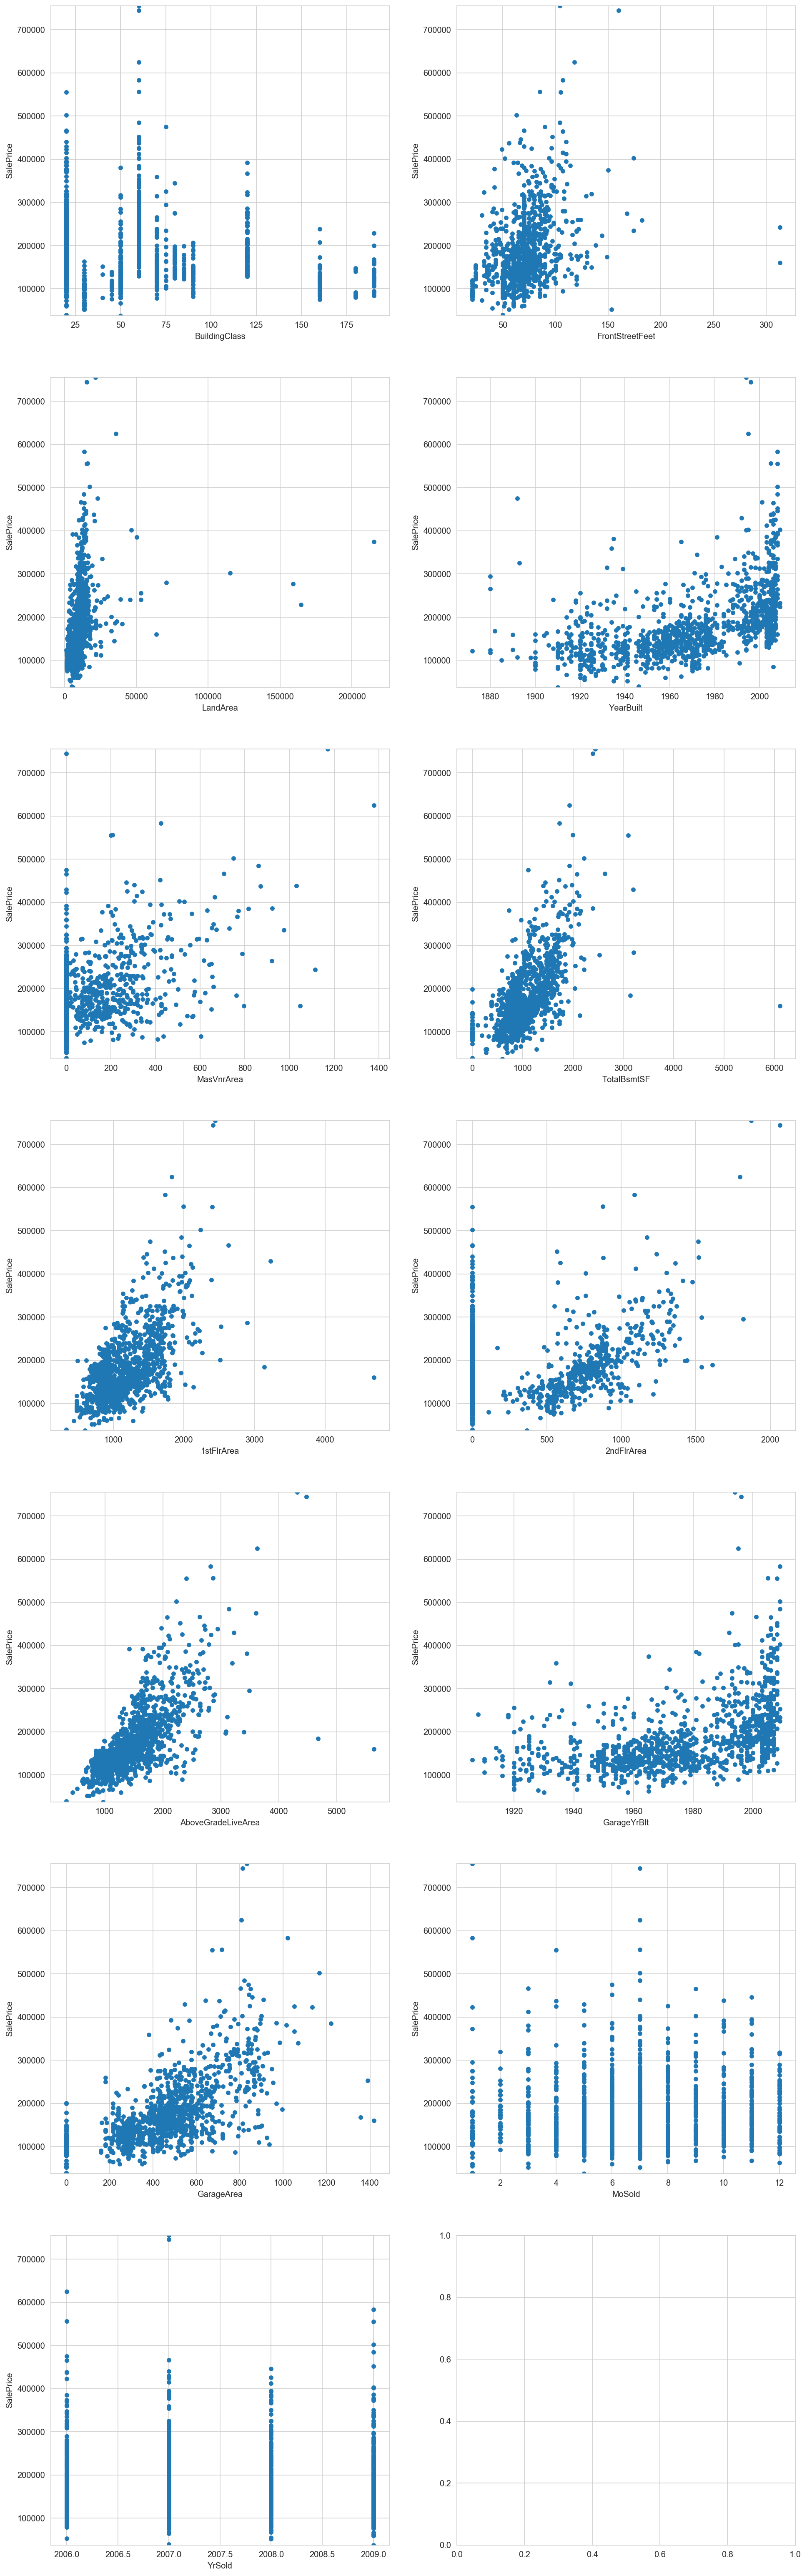

In [62]:
from cLiML import eda
eda.edaContinuous(house_fixed_numbers, 'SalePrice')

In [63]:
def findOutlier(dataframe):
    # for each column
    outlier_dict = {}
    for column in dataframe:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        # calculate the IQR
        IQR = Q3 - Q1
        # get the outliers from that column
        outliers = dataframe[[column]][(dataframe[column] < (Q1 - 1.5*IQR)) | 
                                       (dataframe[column] > (Q3 + 1.5*IQR))]
        
        value = outliers[column].values.tolist()
        if (len(value) > 0):
            key = column
            outlier_dict[key] = value
        
    return outlier_dict

#### Price - outliers

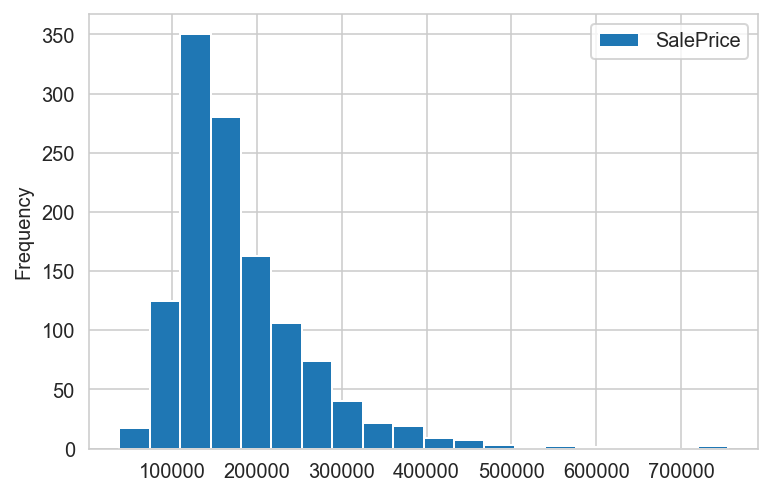

In [64]:
house_fixed[['SalePrice']].plot(kind = 'hist', bins = 20)

In [65]:
# Lots of outliers when it comes to price if 1.5IQR rule is used.
print(findOutlier(house_fixed[['SalePrice']]))

{'SalePrice': [345000, 385000, 438780, 383970, 372402, 412500, 501837, 475000, 386250, 403000, 415298, 360000, 375000, 342643, 354000, 377426, 437154, 426000, 555000, 440000, 380000, 374000, 430000, 402861, 446261, 369900, 451950, 359100, 345000, 350000, 402000, 423000, 372500, 392000, 755000, 361919, 341000, 395000, 485000, 582933, 385000, 350000, 348000, 556581, 424870, 625000, 392500, 745000, 367294, 465000, 381000, 466500, 377500, 340000, 394617]}


In [66]:
# only 2 houses have prices which are greater than 700000.
# Thus, they are being removing as they are acting as outliers in above plots.
house_fixed[house_fixed['SalePrice'] > 700000]

BuildingClass ZoneClassification  FrontStreetFeet  LandArea Street  \
575             60                 RL            104.0     21535   Pave   
990             60                 RL            160.0     15623   Pave   

             Alley LotShape LandContour LotConfig LandSlope  ... 1stFlrArea  \
575  Not Available      IR1         Lvl    Corner       Gtl  ...       2444   
990  Not Available      IR1         Lvl    Corner       Gtl  ...       2411   

    2ndFlrArea AboveGradeLiveArea GarageYrBlt GarageArea  MoSold YrSold  \
575       1872               4316      1994.0        832       1   2007   
990       2065               4476      1996.0        813       7   2007   

     SaleType SaleCondition SalePrice  
575        WD        Normal    755000  
990        WD       Abnorml    745000  

[2 rows x 31 columns]

In [67]:
house_fixed = house_fixed[house_fixed['SalePrice'] < 700000]
house = house[house['SalePrice'] < 700000]

#### FrontStreetFeet Outliers

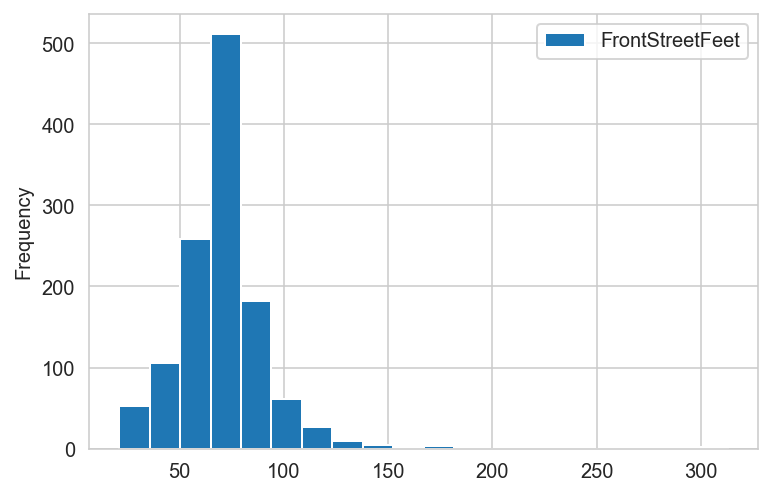

In [68]:
house_fixed[['FrontStreetFeet']].plot(kind = 'hist', bins = 20)

In [69]:
print(findOutlier(house_fixed[['FrontStreetFeet']]))

{'FrontStreetFeet': [110.0, 108.0, 112.0, 115.0, 21.0, 121.0, 122.0, 24.0, 120.0, 134.0, 110.0, 24.0, 24.0, 174.0, 21.0, 21.0, 174.0, 21.0, 21.0, 120.0, 30.0, 120.0, 118.0, 116.0, 150.0, 111.0, 21.0, 109.0, 130.0, 21.0, 24.0, 21.0, 110.0, 21.0, 21.0, 24.0, 130.0, 24.0, 21.0, 120.0, 110.0, 24.0, 30.0, 110.0, 144.0, 114.0, 21.0, 128.0, 116.0, 149.0, 21.0, 313.0, 24.0, 24.0, 122.0, 130.0, 121.0, 21.0, 115.0, 21.0, 21.0, 21.0, 24.0, 24.0, 114.0, 168.0, 182.0, 134.0, 109.0, 120.0, 118.0, 138.0, 21.0, 124.0, 21.0, 313.0, 108.0, 24.0, 153.0, 120.0, 129.0, 124.0, 21.0, 21.0]}


In [70]:
# only 2 houses with FrontStreetFeet > 300, so they are being removed. 
house_fixed[house_fixed['FrontStreetFeet'] > 300]

BuildingClass ZoneClassification  FrontStreetFeet  LandArea Street  \
774              20                 RL            313.0     27650   Pave   
1085             60                 RL            313.0     63887   Pave   

              Alley LotShape LandContour LotConfig LandSlope  ... 1stFlrArea  \
774   Not Available      IR2         HLS    Inside       Mod  ...       2069   
1085  Not Available      IR3         Bnk    Corner       Gtl  ...       4692   

     2ndFlrArea AboveGradeLiveArea GarageYrBlt GarageArea  MoSold YrSold  \
774           0               2069      1960.0        505      11   2008   
1085        950               5642      2008.0       1418       1   2008   

      SaleType SaleCondition SalePrice  
774         WD        Normal    242000  
1085       New       Partial    160000  

[2 rows x 31 columns]

In [71]:
house_fixed = house_fixed[house_fixed['FrontStreetFeet'] < 300]
house = house[house['FrontStreetFeet'] < 300]

#### Land area - Outliers

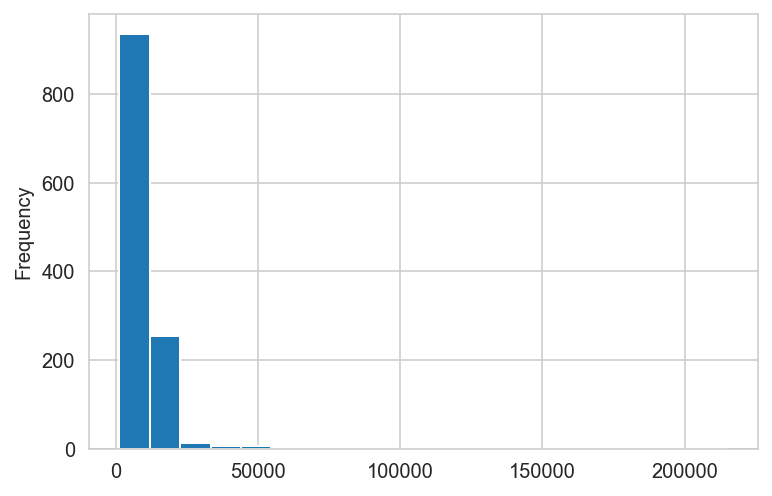

In [72]:
house_fixed['LandArea'].plot(kind = 'hist', bins = 20)

In [73]:
print(findOutlier(house_fixed[['LandArea']]))

{'LandArea': [50271, 21000, 21453, 19378, 22950, 25419, 159000, 19296, 39104, 18386, 215245, 164660, 20431, 18800, 53107, 34650, 22420, 21750, 70761, 53227, 40094, 32668, 21872, 21780, 25095, 46589, 20896, 18450, 26178, 115149, 21695, 21384, 28698, 45600, 25286, 25000, 1300, 21286, 1477, 21750, 29959, 23257, 35760, 18030, 35133, 32463, 18890, 24682, 36500, 20781, 25339, 20544, 19690, 21930]}


In [74]:
# Only 4 houses with area greater than 100000, which are being removed.
house_fixed[house_fixed['LandArea'] > 50000]

BuildingClass ZoneClassification  FrontStreetFeet  LandArea Street  \
43              20                 RL             68.0     50271   Pave   
198             50                 RL             70.0    159000   Pave   
250             20                 RL            150.0    215245   Pave   
270            190                 RL             70.0    164660   Grvl   
309             60                 RL             70.0     53107   Pave   
368             20                 RL             62.0     70761   Pave   
373             20                 RL             70.0     53227   Pave   
585             20                 RL             70.0    115149   Pave   

             Alley LotShape LandContour LotConfig LandSlope  ... 1stFlrArea  \
43   Not Available      IR1         Low    Inside       Gtl  ...       1842   
198  Not Available      IR2         Low   CulDSac       Sev  ...       1444   
250  Not Available      IR3         Low    Inside       Sev  ...       2036   
270  Not Available      IR1         HLS    Corner       Sev  ...       1619   
309  Not Available      IR2         Low    Corner       Mod  ...       1079   
368  Not Available      IR1         Low    Inside       Mod  ...       1533   
373  Not Available      IR1         Low   CulDSac       Mod  ...       1663   
585  Not Available      IR2         Low   CulDSac       Sev  ...       1824   

    2ndFlrArea AboveGradeLiveArea GarageYrBlt GarageArea  MoSold YrSold  \
43           0               1842      1981.0        894      11   2006   
198        700               2144      1958.0        389       6   2007   
250          0               2036      1965.0        513       6   2009   
270        167               1786      1965.0        529       8   2008   
309        874               1953      1992.0        501       6   2007   
368          0               1533      1975.0        576      12   2006   
373          0               1663      1954.0        529       3   2008   
585          0               1824      1971.0        739       6   2007   

     SaleType SaleCondition SalePrice  
43         WD        Normal    385000  
198        WD        Normal    277000  
250        WD        Normal    375000  
270        WD        Normal    228950  
309        WD        Normal    240000  
368        WD        Normal    280000  
373        WD        Normal    256000  
585        WD        Normal    302000  

[8 rows x 31 columns]

In [75]:
house_fixed = house_fixed[house_fixed['LandArea'] < 50000]
house = house[house['LandArea'] < 50000]

#### MasVnrArea - Outlier

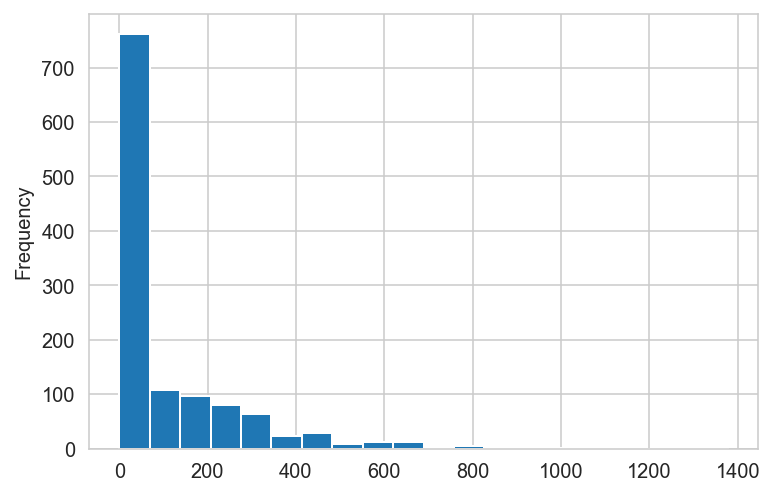

In [76]:
house_fixed['MasVnrArea'].plot(kind = 'hist', bins = 20)

In [77]:
print(findOutlier(house_fixed[['MasVnrArea']]))

{'MasVnrArea': [640.0, 650.0, 1031.0, 573.0, 1115.0, 576.0, 443.0, 468.0, 600.0, 436.0, 456.0, 664.0, 653.0, 491.0, 748.0, 922.0, 506.0, 604.0, 481.0, 616.0, 870.0, 530.0, 500.0, 510.0, 650.0, 473.0, 772.0, 435.0, 562.0, 921.0, 762.0, 594.0, 584.0, 459.0, 452.0, 472.0, 660.0, 528.0, 464.0, 630.0, 466.0, 651.0, 442.0, 513.0, 673.0, 860.0, 424.0, 1047.0, 816.0, 541.0, 423.0, 424.0, 975.0, 423.0, 571.0, 480.0, 425.0, 660.0, 1378.0, 425.0, 766.0, 554.0, 632.0, 567.0, 621.0, 788.0, 428.0, 564.0, 705.0, 731.0, 448.0, 426.0, 438.0]}


In [78]:
# They are not being removed since they are too many.
house_fixed[house_fixed['MasVnrArea'] == 0].shape

(713, 31)

#### TotalBsmtSF - Outlier

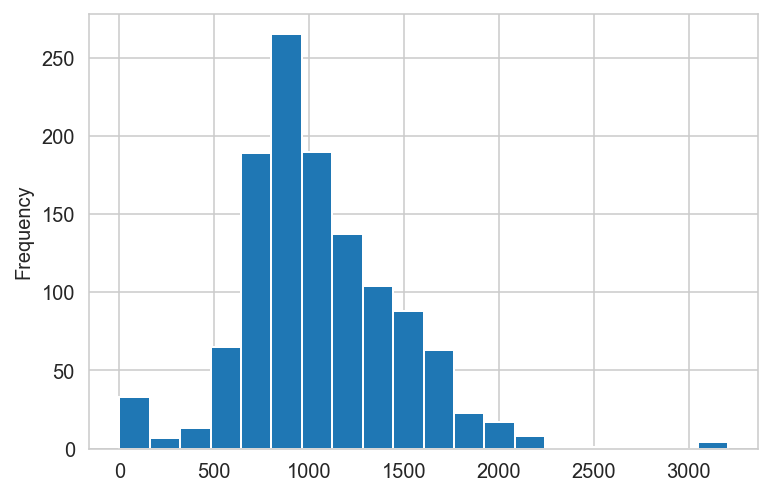

In [79]:
house_fixed['TotalBsmtSF'].plot(kind = 'hist', bins = 20)

In [80]:
print(findOutlier(house_fixed[['TotalBsmtSF']]))

{'TotalBsmtSF': [0, 0, 2223, 0, 0, 0, 2216, 0, 2392, 0, 2121, 3206, 0, 0, 0, 0, 3094, 2153, 3200, 0, 3138, 0, 0, 0, 2109, 2077, 0, 0, 0, 2078, 0, 2217, 0, 0, 0, 0, 0, 2524, 0, 0, 0, 0, 2158, 0, 2136, 0, 2076, 0, 2633, 0]}


In [81]:
# 32 basements with 0 area. that is 2% of the data which is why they are not being removed.
# They should affect the linear regresssion.
house_fixed[house_fixed['TotalBsmtSF'] == 0].shape

(32, 31)

#### 2ndFlrArea - Outlier

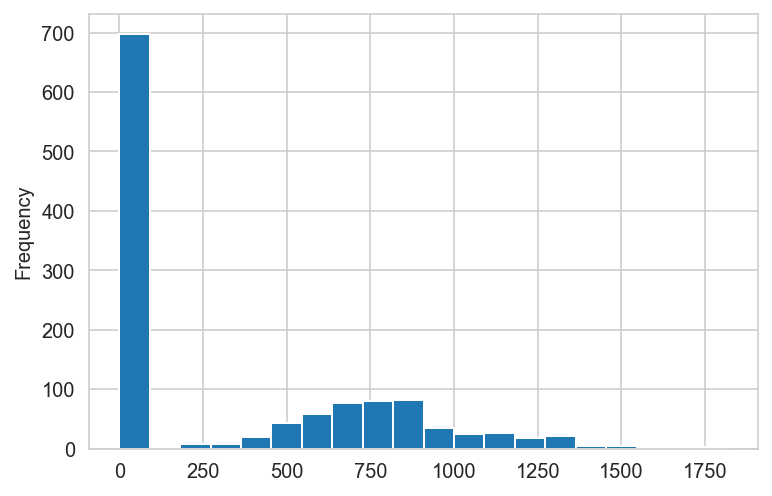

In [82]:
house_fixed['2ndFlrArea'].plot(kind = 'hist', bins = 20)

In [83]:
# Too many hourses have no 2nd floor area. This does make sense.
# However, the 2ndFlrArea variable is really going to be a bad predictor
# Thus, they are being removed.
house_fixed[house_fixed['2ndFlrArea'] == 0].shape

(697, 31)

#### Looking at correlation between YearBuilt and GarageYrBlt

In [84]:
# High correlation between these two variables can be seen.
house_fixed[['YearBuilt', 'GarageYrBlt']].corr()

YearBuilt  GarageYrBlt
YearBuilt     1.000000     0.824009
GarageYrBlt   0.824009     1.000000

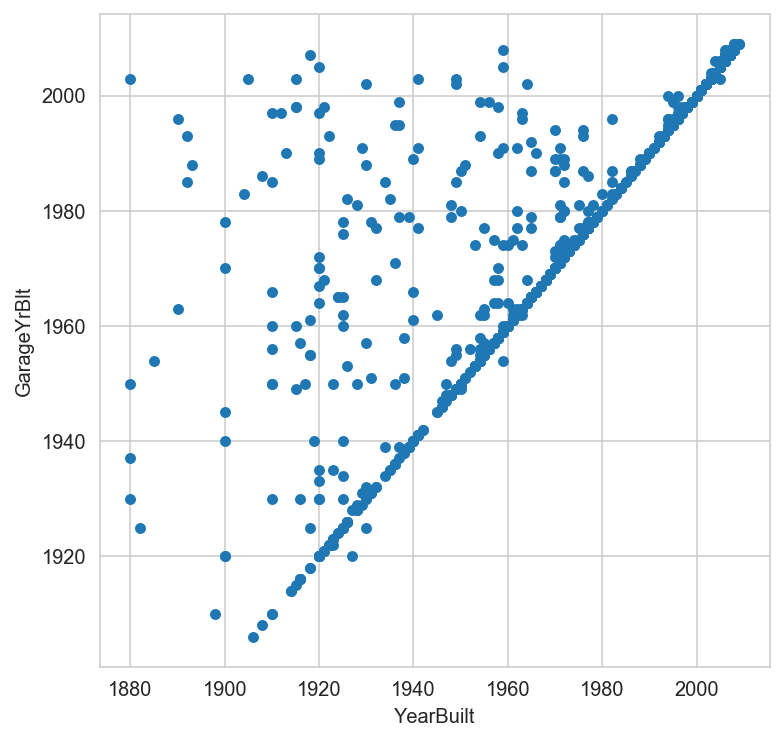

In [85]:
house_fixed[['YearBuilt', 'GarageYrBlt']].plot(kind = 'scatter', x = 'YearBuilt', y = 'GarageYrBlt', figsize = (6,6))

In [86]:
# Lots of houses with no garage.
# It has very low impact on the overall trend, so they are being kept.
house_fixed[house_fixed['GarageArea'] == 0].shape

(68, 31)

#### Month and year provide more accurate categorical variables

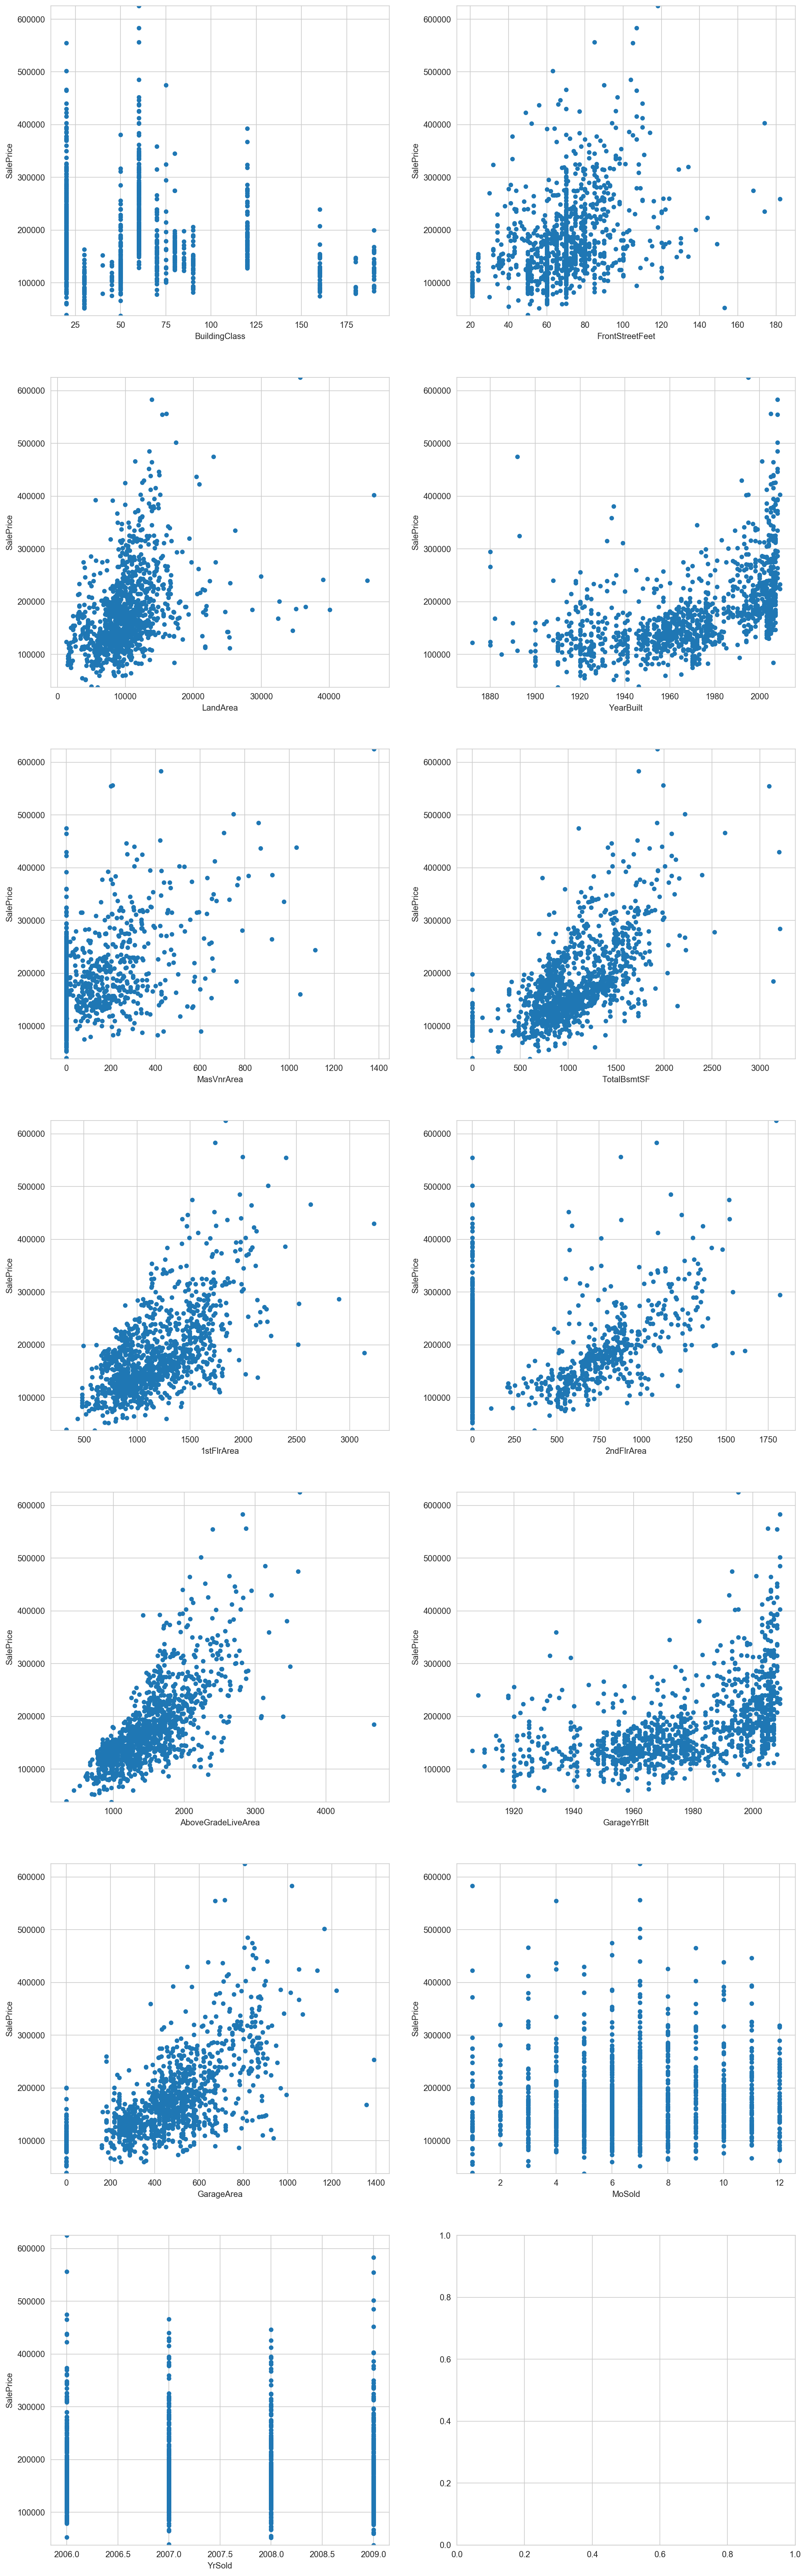

In [87]:
from cLiML import eda
eda.edaContinuous(house_fixed, 'SalePrice')

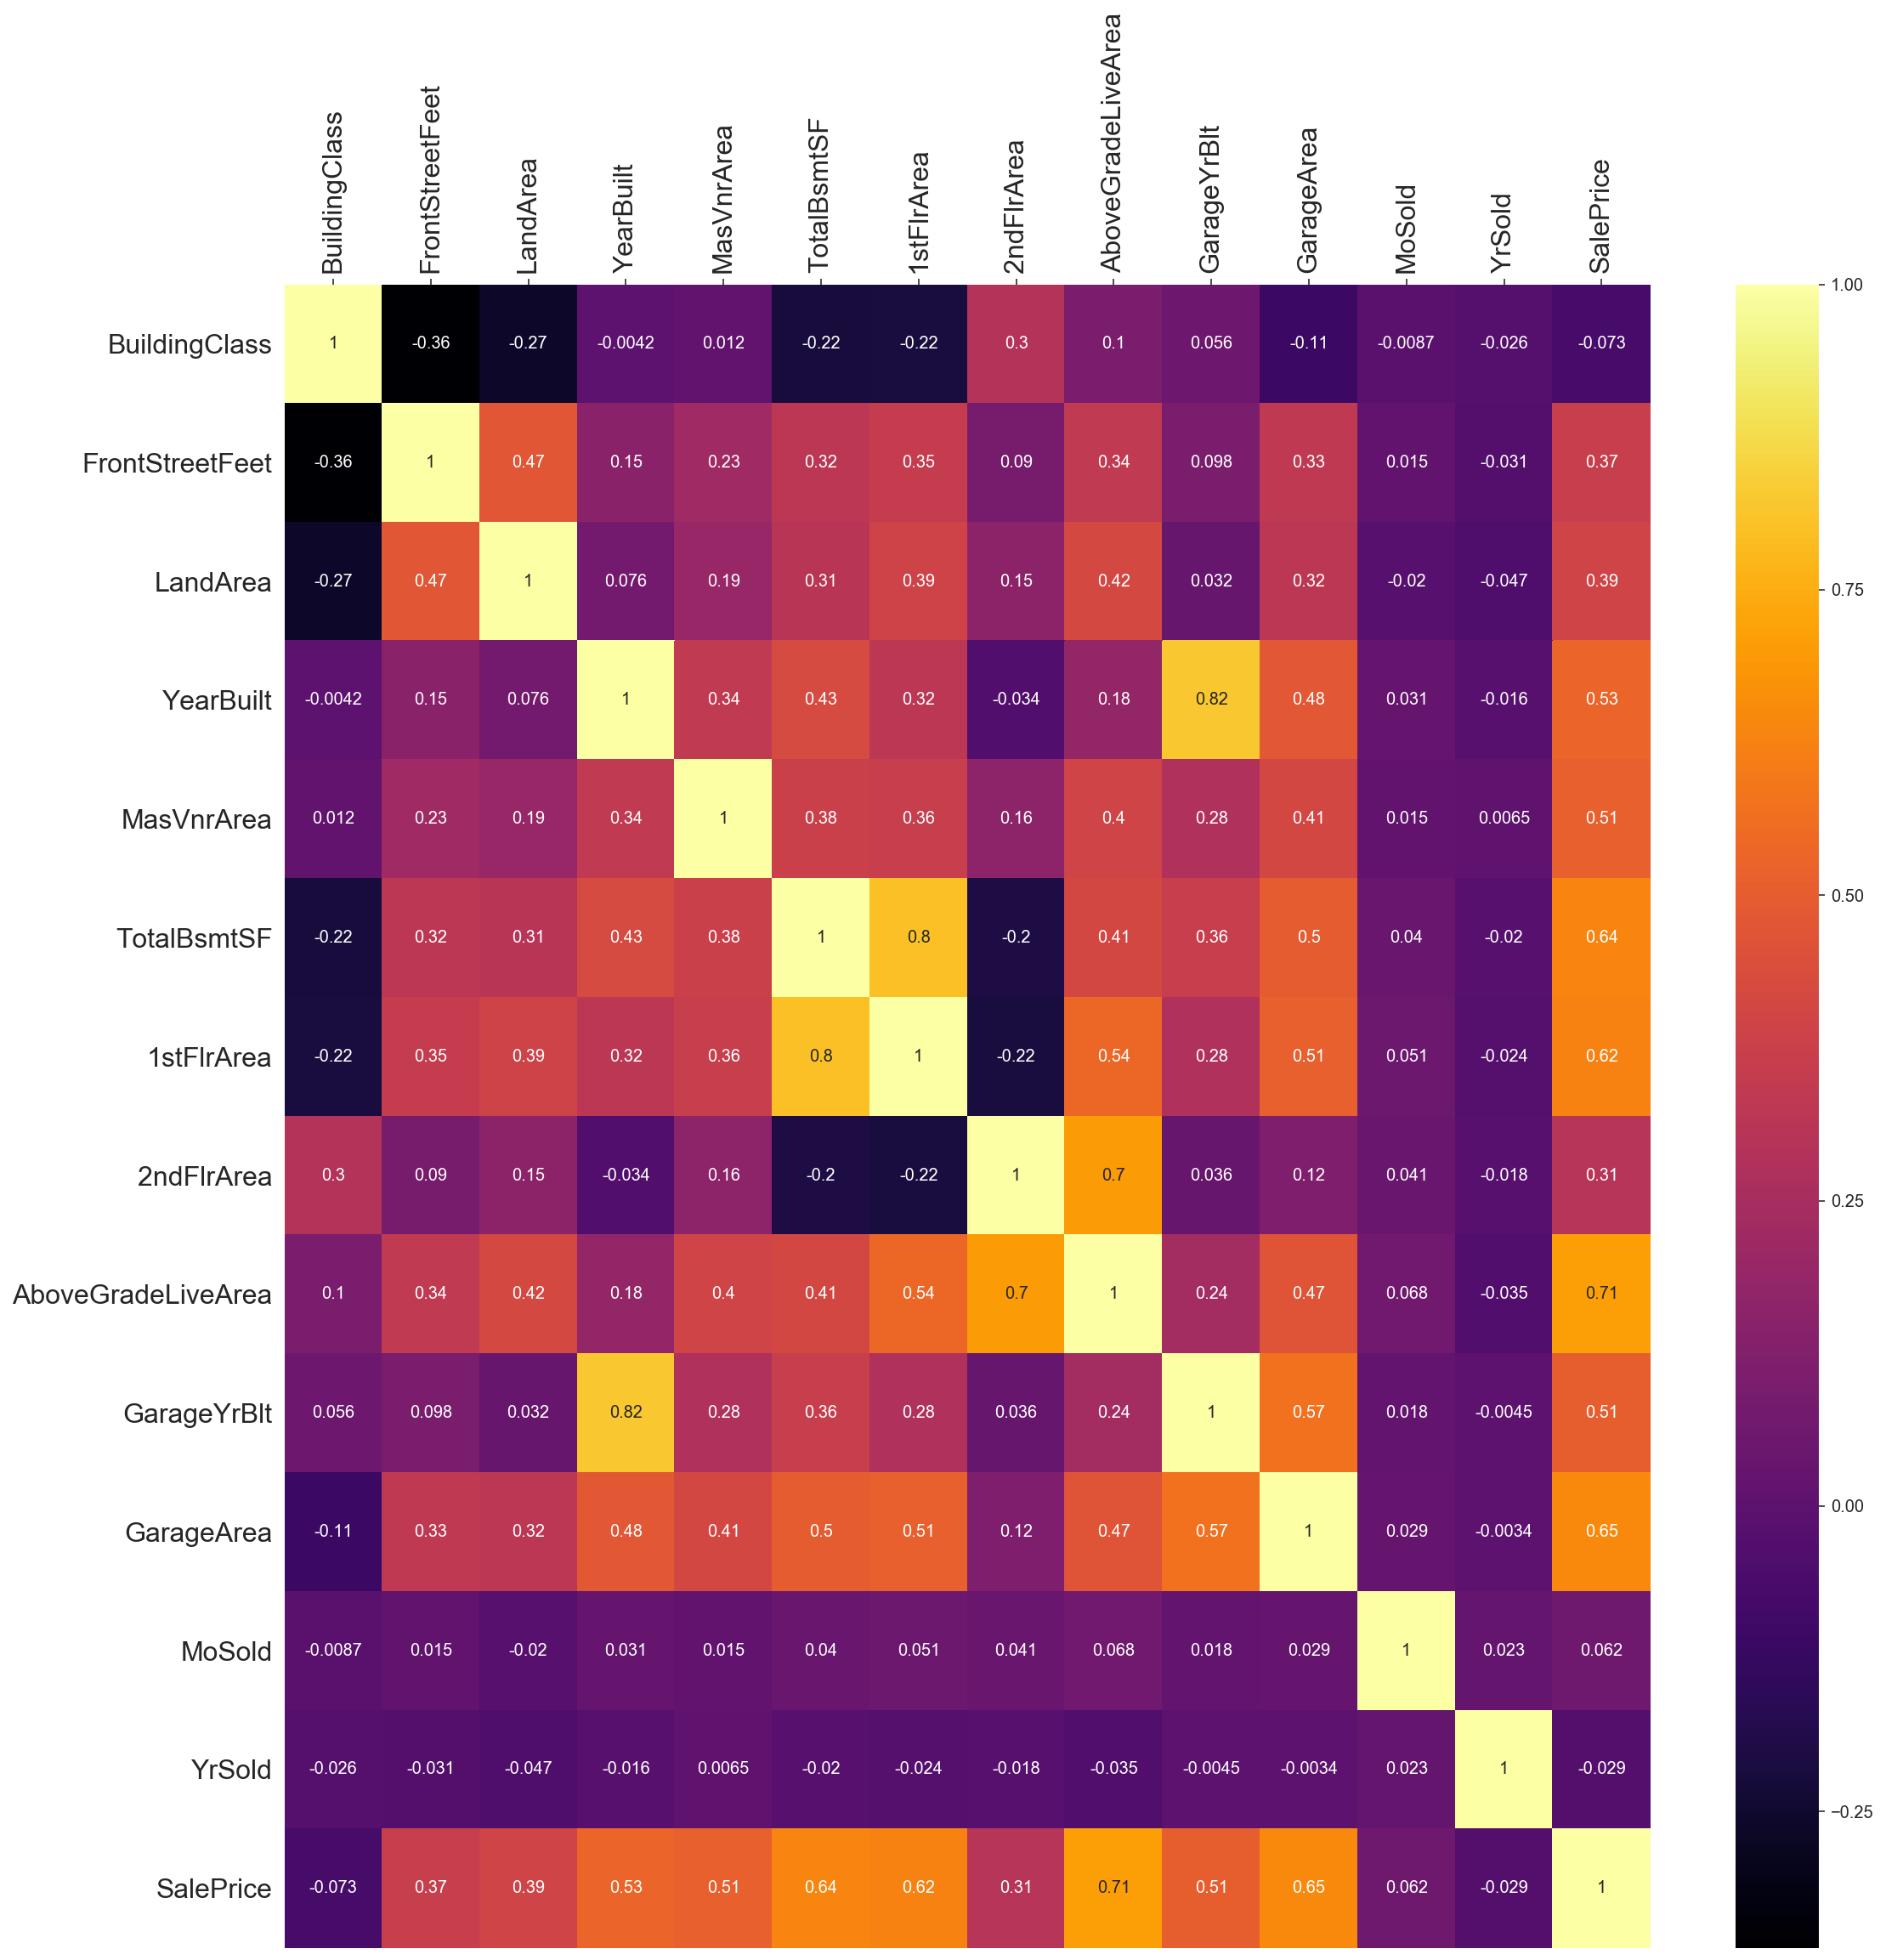

In [88]:
fig, ax = plt.subplots(figsize=(18,18))
ax = sns.heatmap(house_fixed.corr(), annot=True, cmap = 'inferno')
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
ax.tick_params(labelsize=16)

In [89]:
## Variables that are bad predictors
['2ndFlrArea', 'FrontStreetFeet', 'LandArea']

## Variables that acts better as categorical variables
number_cate_var = ['BuildingClass', 'MoSold']

#### Look at categorical variable

In [90]:
house_fixed_categorical_var = []
for var in house_fixed.columns.values.tolist():
    if var not in number_variables:
        house_fixed_categorical_var.append(var)
        

In [91]:
## Adding those columns that are numbers, but are better represented as categorical data
for item in number_cate_var:
    house_fixed_categorical_var.append(item)
    
# Adding SalePrice
house_fixed_categorical_var.append('SalePrice')

In [92]:
house_fixed_categorical = house_fixed[house_fixed_categorical_var]

In [93]:
house_fixed_categorical.head(2)

ZoneClassification Street          Alley LotShape LandContour LotConfig  \
0                 RL   Pave  Not Available      Reg         Lvl    Inside   
1                 RL   Pave  Not Available      Reg         Lvl       FR2   

  LandSlope Neighborhood ProxiToRoadRail1 ProxiToRoadRail2 BldgType  \
0       Gtl      CollgCr             Norm             Norm     1Fam   
1       Gtl      Veenker            Feedr             Norm     1Fam   

  HouseStyle MasVnrType Foundation BsmtHeight SaleType SaleCondition  \
0     2Story    BrkFace      PConc         Gd       WD        Normal   
1     1Story       None     CBlock         Gd       WD        Normal   

   BuildingClass  MoSold  SalePrice  
0             60       2     208500  
1             20       5     181500

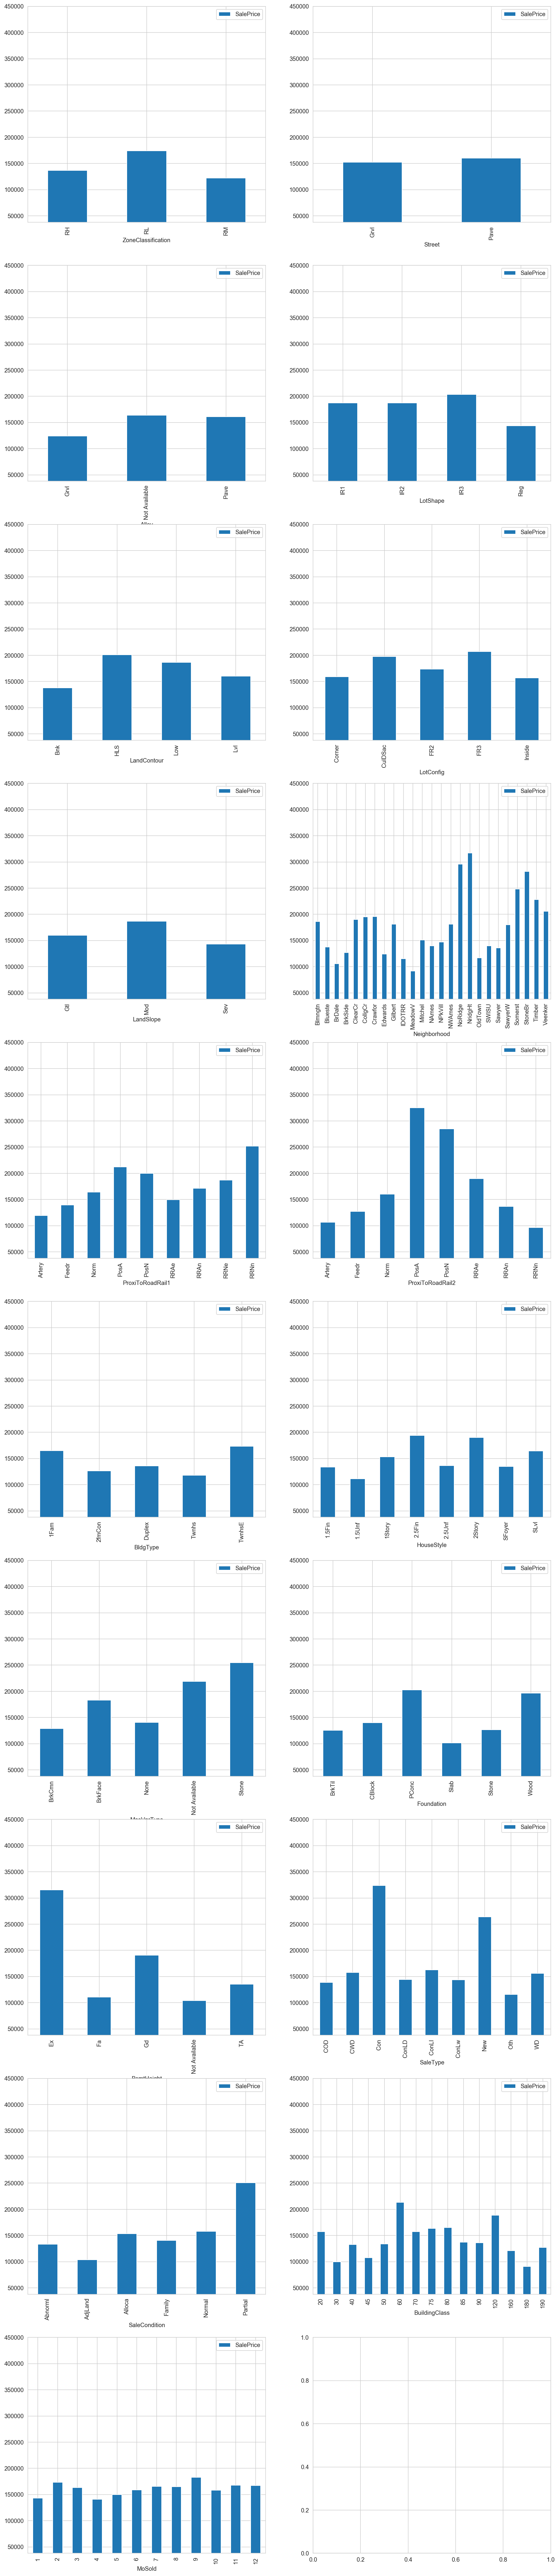

In [94]:
from cLiML import eda
eda.edaCategorical(house_fixed_categorical, 'SalePrice', max_y_axis = 450000 )

In [95]:
## bad categorical variables
['ZoneClassification', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'BldgType', 'MoSold', 'YrSold']

['ZoneClassification',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'BldgType',
 'MoSold',
 'YrSold']

### Feature selection

#### manipulating validated and test data into the same shape

In [96]:
house_test_fixed = house_test[fixed]

#### Removing garage yr built due to null values and high colinearity


In [97]:
house_fixed.drop(columns = ['GarageYrBlt', 'SaleCondition'], inplace = True)
house_test_fixed.drop(columns = ['GarageYrBlt', 'SaleCondition'], inplace = True)

/Users/siavashmaleki/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [98]:
### dummify variables
all_known_cat_var = house_fixed_categorical.columns.values.tolist()
all_known_cat_var.remove('SalePrice')
all_known_cat_var.remove('SaleCondition')

In [99]:
from cLiML import model_prep
df_fixed = model_prep.dummify(house_fixed, all_known_cat_var)

df_test_fixed = model_prep.dummify_test(house_test_fixed, all_known_cat_var)

In [100]:
df_test_fixed = model_prep.match_test_to_train_columns(df_test_fixed, df_fixed)

#### Splitting data into train and test

In [101]:
y_fixed = df_fixed['SalePrice']
X_fixed = df_fixed.drop(columns = ['SalePrice'])


y_test_fixed = df_test_fixed['SalePrice']
X_test_fixed = df_test_fixed.drop(columns = ['SalePrice'])

#### Feature scaling

In [102]:
from cLiML import model_prep

In [103]:
Xs_fixed = model_prep.standardize_X_train(X_fixed)

Xs_test_fixed = model_prep.standardize_X_test(X_test_fixed, X_fixed)

### Using feature selection from cLiML

In [104]:
from cLiML import model_prep

In [105]:
df_feat = model_prep.feature_select_linear_reg(X_fixed, y_fixed, cv = 5)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [106]:
df_feat

variable_RFECV  support  ranking           variable_skb  \
0             FrontStreetFeet     True        1     AboveGradeLiveArea   
1    BsmtHeight_Not Available     True        1             GarageArea   
2               BsmtHeight_Gd     True        1            TotalBsmtSF   
3               BsmtHeight_Fa     True        1             1stFlrArea   
4               BsmtHeight_Ex     True        1          BsmtHeight_Ex   
5            Foundation_Stone     True        1              YearBuilt   
6             Foundation_Slab     True        1             MasVnrArea   
7            Foundation_PConc     True        1       Foundation_PConc   
8           Foundation_CBlock     True        1   Neighborhood_NridgHt   
9           Foundation_BrkTil     True        1        MasVnrType_None   
10   MasVnrType_Not Available     True        1               LandArea   
11            MasVnrType_None     True        1           SaleType_New   
12         MasVnrType_BrkFace     True        1       BuildingClass_60   
13               SaleType_COD     True        1        FrontStreetFeet   
14          MasVnrType_BrkCmn     True        1      Foundation_CBlock   
15          HouseStyle_2Story     True        1             2ndFlrArea   
16          HouseStyle_2.5Unf     True        1  ZoneClassification_RL   
17          HouseStyle_2.5Fin     True        1   Neighborhood_NoRidge   
18          HouseStyle_1Story     True        1      HouseStyle_2Story   
19          HouseStyle_1.5Unf     True        1          BsmtHeight_Gd   
20          HouseStyle_1.5Fin     True        1       BuildingClass_30   
21             BldgType_Twnhs     True        1           LotShape_IR1   
22            BldgType_Duplex     True        1     MasVnrType_BrkFace   
23            BldgType_2fmCon     True        1   Neighborhood_StoneBr   
24              BldgType_1Fam     True        1      Foundation_BrkTil   
25      ProxiToRoadRail2_RRAn     True        1     Neighborhood_NAmes   
26      ProxiToRoadRail2_RRAe     True        1   Neighborhood_OldTown   
27          HouseStyle_SFoyer     True        1   Neighborhood_Edwards   
28               SaleType_CWD     True        1      HouseStyle_1.5Fin   
29               SaleType_Con     True        1       BuildingClass_50   
..                        ...      ...      ...                    ...   
93      ProxiToRoadRail1_RRNe     True        1               MoSold_6   
94      ProxiToRoadRail1_RRAn     True        1                 YrSold   
95      ProxiToRoadRail1_RRAe     True        1          LandSlope_Gtl   
96      ProxiToRoadRail1_PosN     True        1  ProxiToRoadRail1_PosA   
97      ProxiToRoadRail1_PosA     True        1           LotShape_IR3   
98      ProxiToRoadRail1_Norm     True        1          LotConfig_FR3   
99     ProxiToRoadRail1_Feedr     True        1   Neighborhood_Blmngtn   
100   ProxiToRoadRail1_Artery     True        1       BuildingClass_80   
101       Neighborhood_Timber     True        1         SaleType_ConLD   
102      Neighborhood_StoneBr     True        1      HouseStyle_2.5Unf   
103      Neighborhood_CollgCr     True        1   Neighborhood_SawyerW   
104      Neighborhood_SawyerW     True        1   Neighborhood_Blueste   
105      Neighborhood_Somerst     True        1       BuildingClass_75   
106        Neighborhood_SWISU     True        1  ProxiToRoadRail2_Norm   
107      Neighborhood_OldTown     True        1        LandContour_Low   
108      Neighborhood_NridgHt     True        1       LotConfig_Corner   
109      Neighborhood_NoRidge     True        1   Neighborhood_ClearCr   
110       Neighborhood_NWAmes     True        1               MoSold_1   
111      Neighborhood_NPkVill     True        1       Foundation_Stone   
112        Neighborhood_NAmes     True        1  ProxiToRoadRail2_RRAn   
113      Neighborhood_Mitchel     True        1               MoSold_8   
114       Neighborhood_Sawyer     True        1            Street_Grvl   
115      Neighborho

#### Performing Recursive Feature Elimination

In [107]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
cv_scores = []
for i in range(1,df_feat['ranking'].max() + 1):
    columns_RFE = df_feat[df_feat['ranking'] <= i]['variable_RFECV'].values.tolist()
    ## performing a simple linear regression 
    lr_fixed = LinearRegression()
    
    cv_scores.append(np.mean(cross_val_score(lr_fixed, X_fixed[columns_RFE], y_fixed, cv = 5)))


print('max score', max(cv_scores))

print('rank', cv_scores.index(max(cv_scores)) + 1)


max score 0.8045710252592035
rank 3


In [108]:
columns_RFE = df_feat[df_feat['ranking'] <= 3]['variable_RFECV'].values.tolist()

In [109]:
## performing a simple linear regression
from sklearn.linear_model import LinearRegression
lr_fixed = LinearRegression()
fixed_predictor = lr_fixed.fit(X_fixed[columns_RFE], y_fixed)

y_test_fixed_pred = fixed_predictor.predict(X_test_fixed[columns_RFE])

In [110]:
fixed_predictor.score(X_fixed[columns_RFE], y_fixed)

0.8717236085153806

In [111]:
fixed_predictor.score(X_test_fixed[columns_RFE], y_test_fixed)

0.8643328882687384

In [112]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_fixed, y_test_fixed_pred)

888971719.5600573

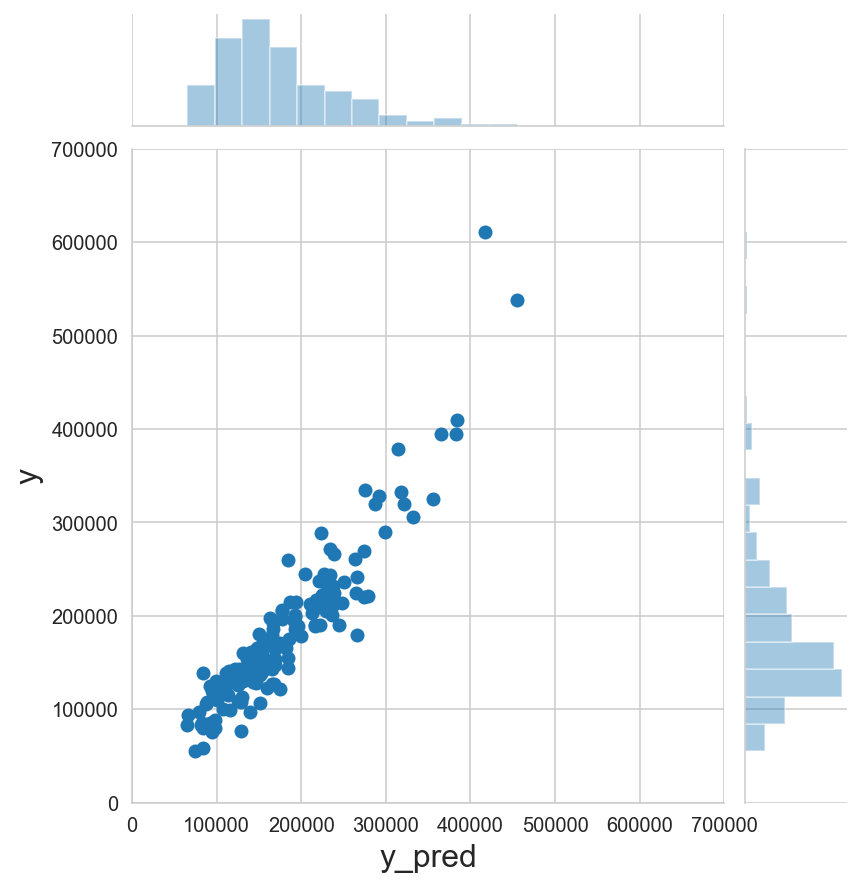

In [113]:
ax = sns.jointplot(x = y_test_fixed_pred, y = y_test_fixed,ylim=(0, 700000), xlim = (0,700000), label = 'y_pred')
ax.set_axis_labels('y_pred', 'y', fontsize=16)



In [114]:
var = X_fixed[columns_RFE].values.tolist()
coef_val = fixed_predictor.coef_.tolist()
coef_val_abs = abs(fixed_predictor.coef_).tolist()

coef_df = pd.DataFrame({'variable': columns_RFE,
                       'coefficients': coef_val,
                       'coef_abs': coef_val_abs}).sort_values('coef_abs', ascending = False)

In [115]:
coef_df

variable   coefficients       coef_abs
58      ProxiToRoadRail2_PosN -187899.001056  187899.001056
59      ProxiToRoadRail2_PosA   96901.446804   96901.446804
29               SaleType_Con   83291.616345   83291.616345
41          BuildingClass_160  -68996.729398   68996.729398
40          BuildingClass_180  -60250.325677   60250.325677
16          HouseStyle_2.5Unf  -57888.296443   57888.296443
44           BuildingClass_85  -54754.873127   54754.873127
113      Neighborhood_Mitchel  -45525.570855   45525.570855
45           BuildingClass_80  -45505.457930   45505.457930
42          BuildingClass_120  -44955.039265   44955.039265
50           BuildingClass_45  -43196.187555   43196.187555
4               BsmtHeight_Ex   40811.170988   40811.170988
117      Neighborhood_Edwards  -39227.869473   39227.869473
110       Neighborhood_NWAmes  -38253.729248   38253.729248
107      Neighborhood_OldTown  -38115.494016   38115.494016
49           BuildingClass_50  -36843.197185   36843.197185
112        Neighborhood_NAmes  -36193.613468   36193.613468
17          HouseStyle_2.5Fin  -36054.645029   36054.645029
114       Neighborhood_Sawyer  -36040.152791   36040.152791
95      ProxiToRoadRail1_RRAe  -34934.576913   34934.576913
118      Neighborhood_Gilbert  -34747.291003   34747.291003
106        Neighborhood_SWISU  -33909.951778   33909.951778
116       Neighborhood_IDOTRR  -33758.973115   33758.973115
102      Neighborhood_StoneBr   32236.428985   32236.428985
103      Neighborhood_CollgCr  -31267.883020   31267.883020
14          MasVnrType_BrkCmn  -30763.264593   30763.264593
52           BuildingClass_30  -30610.508961   30610.508961
53           BuildingClass_20  -30450.652387   30450.652387
43           BuildingClass_90  -29692.598596   29692.598596
22            BldgType_Duplex  -29692.598596   29692.598596
..                        ...            ...            ...
71            LandContour_Low   -3577.329684    3577.329684
2               BsmtHeight_Gd    3538.581361    3538.581361
62        Neighborhood_BrDale   -2743.251540    2743.251540
36                   MoSold_4    2664.853732    2664.853732
91       Neighborhood_Crawfor   -2515.954705    2515.954705
90                  MoSold_11   -2178.361186    2178.361186
70           LotConfig_Corner   -2129.895260    2129.895260
19          HouseStyle_1.5Unf   -2027.541886    2027.541886
10   MasVnrType_Not Available    1386.351045    1386.351045
30             SaleType_ConLD    1355.679116    1355.679116
98      ProxiToRoadRail1_Norm   -1354.898006    1354.898006
75               LotShape_IR3    1346.393767    1346.393767
37                   MoSold_3   -1050.568051    1050.568051
31                   MoSold_9     948.983165     948.983165
94      ProxiToRoadRail1_RRAn    -843.528432     843.528432
80      ZoneClassification_RL     841.670568     841.670568
3               BsmtHeight_Fa     824.302521     824.302521
54               SaleType_Oth    -805.743914     805.743914
76               LotShape_IR1    -703.520079     703.520079
96      ProxiToRoadRail1_PosN     617.465711     617.465711
32                   MoSold_8     595.817573     595.817573
87                  YearBuilt     423.070385     423.070385
119                 MoSold_10    -168.734390     168.734390
82                     YrSold    -115.085449     115.085449
84                 2ndFlrArea      61.614128      61.614128
85                 1stFlrArea      60.455033      60.455033
0             FrontStreetFeet      35.089241      35.089241
86                 MasVnrArea      34.491035      34.491035
83                 GarageArea      31.580904      31.580904
120               TotalBsmtSF      30.747285      30.747285

[121 rows x 3 columns]

### Bagging the Linear regression model

In [116]:
from sklearn.ensemble import BaggingRegressor
lr = LinearRegression()
bag = BaggingRegressor(lr, n_estimators = 4)
bag.fit(X_fixed[columns_RFE], y_fixed)


BaggingRegressor(base_estimator=LinearRegression(copy_X=True,
                                                 fit_intercept=True,
                                                 n_jobs=None, normalize=False),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=1.0, n_estimators=4, n_jobs=None, oob_score=False,
                 random_state=None, verbose=0, warm_start=False)

In [117]:
bag.score(X_fixed[columns_RFE], y_fixed)

0.8664298941227322

In [118]:
bag.score(X_test_fixed[columns_RFE], y_test_fixed)

0.8589194064176853

In [119]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_fixed, bag.predict(X_test_fixed[columns_RFE]))

924444076.9245362

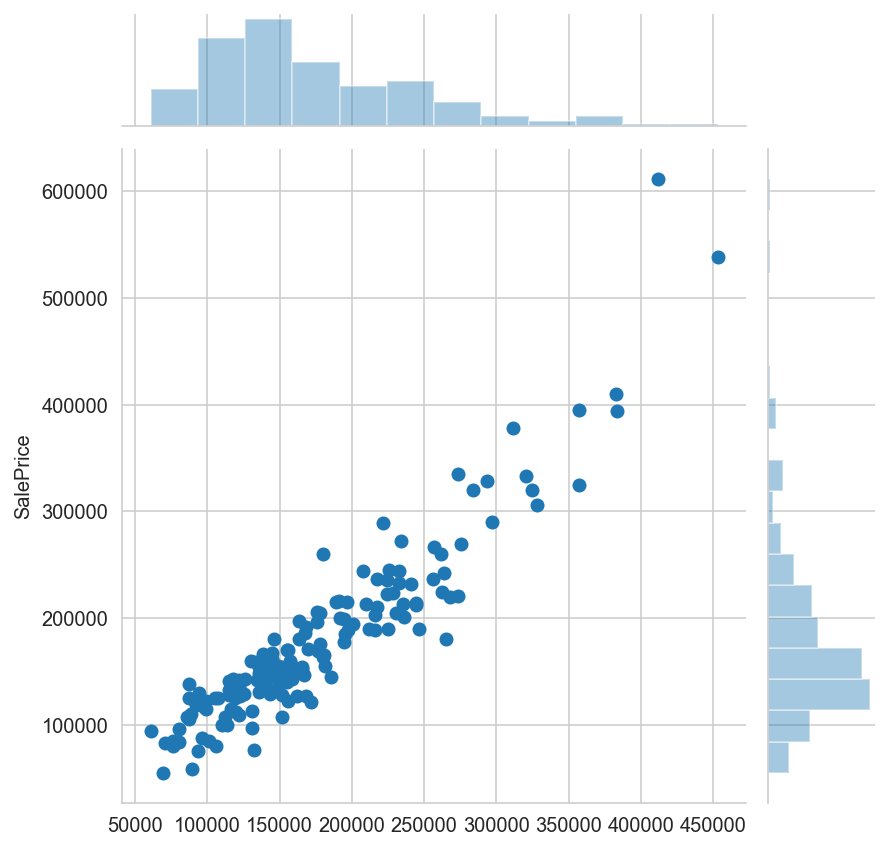

In [120]:
sns.jointplot(x = bag.predict(X_test_fixed[columns_RFE]), y = y_test_fixed)

### SGDRegressor with grid search to make a better model

In [121]:
np.arange(0, 150,2)/100

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48])

In [122]:
np.arange(300, 350)/1000

array([0.3  , 0.301, 0.302, 0.303, 0.304, 0.305, 0.306, 0.307, 0.308,
       0.309, 0.31 , 0.311, 0.312, 0.313, 0.314, 0.315, 0.316, 0.317,
       0.318, 0.319, 0.32 , 0.321, 0.322, 0.323, 0.324, 0.325, 0.326,
       0.327, 0.328, 0.329, 0.33 , 0.331, 0.332, 0.333, 0.334, 0.335,
       0.336, 0.337, 0.338, 0.339, 0.34 , 0.341, 0.342, 0.343, 0.344,
       0.345, 0.346, 0.347, 0.348, 0.349])

In [123]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
sgd_params = {
    'loss': ['squared_loss'],
    'penalty': ['l2'],
    'alpha': [0.43],
    'l1_ratio': [0.23]
}

sgd_reg = SGDRegressor()
sgd_reg_gs = GridSearchCV(sgd_reg, sgd_params, cv = 5, verbose = False)


In [124]:
sgd_reg_gs.fit(Xs_fixed, y_fixed)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0.001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.43], 'l1_ratio': [0.23],
                         'loss': ['squared_loss'], 'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring

In [125]:
sgd_reg_gs.score(Xs_fixed, y_fixed)

0.8327779201321548

In [126]:
sgd_reg_gs.score(Xs_test_fixed, y_test_fixed)

0.8205509861572614

In [127]:
sgd_reg_gs.best_params_

{'alpha': 0.43, 'l1_ratio': 0.23, 'loss': 'squared_loss', 'penalty': 'l2'}

In [128]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_fixed, sgd_reg_gs.predict(Xs_test_fixed))

1175856818.748628

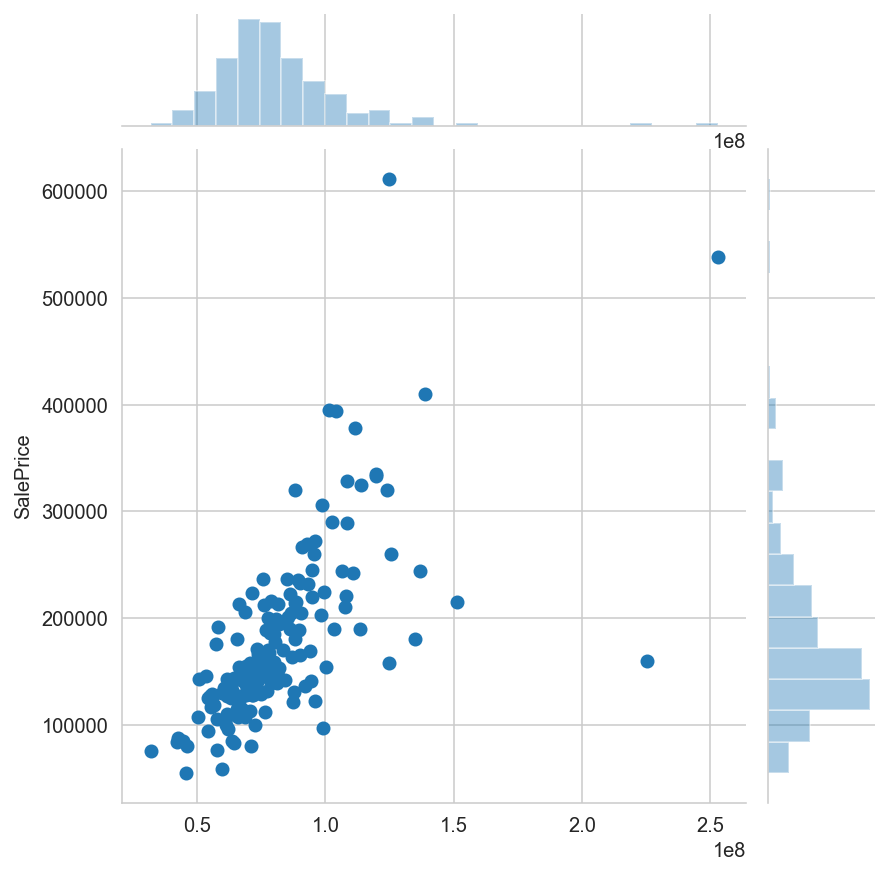

In [129]:
y_test_fixed_pred_GC = sgd_reg_gs.predict(X_test_fixed)
sns.jointplot(x = y_test_fixed_pred_GC, y = y_test_fixed)

In [130]:
def RSS(y, y_pred):
    import numpy as np
    value = np.square(y - y_pred)
    return np.sum(value)

#### plot optimization (needs improvement)


- This section aims to find the characteristics of the houses that have potential to improve their value by renovation.

- This is being done by looking at the mean, median house sold for with highly renovated variables, vs badly revnovated. Grouping the houses according to their location and perhaps size, to keep other variables constant for better comparison.

- The renovating variables generating the biggest price increase can be found by comparing the price difference between the two models.

- The most important renovating varibales can also be found using feature selection.


In [131]:
house = pd.read_csv('house_train.csv')
house.drop(columns = ['Unnamed: 0'], inplace = True)

house_test = pd.read_csv('house_test.csv')
house_test.drop(columns = ['Unnamed: 0'], inplace = True)

In [132]:
renovateable = ['SalePrice', 'ExterQual', 'ExterCond', 'BsmtCond','BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual','Functional','FireplaceQu', 'GarageQual', 'PavedDrive', 'PoolQC', 'FenceQual']

In [133]:
renovateable

['SalePrice',
 'ExterQual',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageQual',
 'PavedDrive',
 'PoolQC',
 'FenceQual']

In [134]:
renovate_cat = ['ExterQual',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageQual',
 'PavedDrive',
 'PoolQC',
 'FenceQual']

In [135]:
df_train = house[renovateable]
df_test = house_test[renovateable]

In [136]:
df_train_dummy = model_prep.dummify(df_train, renovate_cat)
df_test_dummy = model_prep.dummify_test(df_test, renovate_cat)
df_test_dummy = model_prep.match_test_to_train_columns(df_test_dummy, df_train_dummy)


In [137]:
df_train_dummy.shape

(1221, 72)

In [138]:
df_test_dummy.shape

(164, 72)

In [139]:
X_train = df_train_dummy.drop(columns = ['SalePrice'])
y_train = df_train_dummy['SalePrice']

X_test = df_test_dummy.drop(columns = ['SalePrice'])
y_test = df_test_dummy['SalePrice']

In [140]:
df_ft = model_prep.feature_select_linear_reg(X_train, y_train, cv = 5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [141]:
df_ft.head()

variable_RFECV  support  ranking               variable_skb       score  \
0   BsmtFullBath     True        1                   FullBath  566.451738   
1  Heating_Floor     True        1             KitchenQual_Ex  391.442587   
2   Heating_GasA     True        1  FireplaceQu_Not Available  369.844534   
3   Heating_GasW     True        1               ExterQual_Gd  326.656959   
4   Heating_Grav     True        1               ExterQual_Ex  295.946617   

              Variable_Lasso  Coefficients      CoeffAbs  
0                   FullBath  19409.532762  19409.532762  
1             KitchenQual_Ex  16826.861341  16826.861341  
2               ExterQual_Ex  16379.479860  16379.479860  
3               ExterQual_Gd  12051.417314  12051.417314  
4  FireplaceQu_Not Available -11579.321822  11579.321822

In [142]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
cv_scores = []
for i in range(1,df_ft['ranking'].max() + 1):
    columns_RFE = df_ft[df_ft['ranking'] <= i]['variable_RFECV'].values.tolist()
    ## performing a simple linear regression
    lr = LinearRegression()
    
    cv_scores.append(np.mean(cross_val_score(lr, X_train[columns_RFE], y_train, cv = 5)))


print('max score', max(cv_scores))

print('rank', cv_scores.index(max(cv_scores)) + 1)

cv_scores

max score 0.6613132773629891
rank 5


[0.6605463030599082,
 0.6605408358267765,
 0.6611530451615505,
 -2.443215152131022e+20,
 0.6613132773629891,
 -7.340080062657323e+20,
 0.6602903709786616,
 0.6602224195381303,
 -3.2322101639535506e+20,
 -2.058649348112718e+21,
 -8.730753225221277e+20,
 -2.4205399924540046e+22,
 -2.5832438996598606e+21,
 -5.877040700826761e+22,
 -1.7480179202347376e+23,
 -1.6013477215073995e+23,
 -1.0237404042116455e+23,
 -1.1475778513362583e+23,
 -1.0097725927334927e+23,
 -8.437024283678028e+21,
 -8.530694726256541e+22,
 -6.171228926795633e+22,
 -6.664037313597173e+21,
 -3.721659750467577e+23,
 -7.305735866481001e+21,
 -1.54665362685913e+22,
 -6.1236731925835136e+22]

In [143]:
columns_RFE = df_ft[df_ft['ranking'] <= 4]['variable_RFECV'].values.tolist()

lr = LinearRegression()
lr.fit(X_train[columns_RFE], y_train)
y_test_pred = lr.predict(X_test[columns_RFE])

In [144]:
lr.score(X_train[columns_RFE], y_train)

0.7313753628372746

In [145]:
lr.score(X_test[columns_RFE], y_test)

0.7485923863218565

In [146]:
mean_squared_error(y_test_pred, y_test)

1647372423.4998248

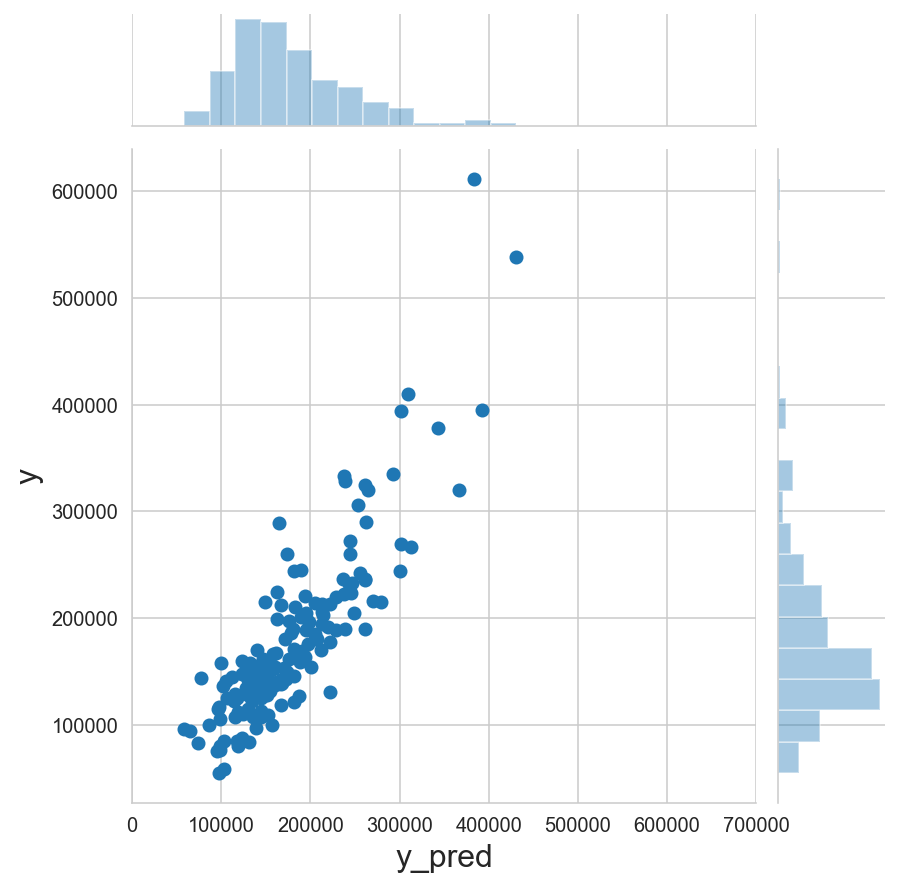

In [147]:
ax = sns.jointplot(x = y_test_pred, y = y_test, xlim = (0,700000), label = 'y_pred')
ax.set_axis_labels('y_pred', 'y', fontsize=16)

In [148]:
## coefficients
var = X_train[columns_RFE].values.tolist()
coef_val = lr.coef_.tolist()
coef_val_abs = abs(lr.coef_).tolist()


In [149]:
len(coef_val)

48

In [150]:
len(columns_RFE)

48

In [151]:
coef_df = pd.DataFrame({'variable': columns_RFE,
                       'coefficients': coef_val,
                       'coef_abs': coef_val_abs}).sort_values('coef_abs', ascending = False)

In [152]:
coef_df.sort_values('variable', ascending = False)

variable   coefficients       coef_abs
34                   PoolQC_Gd  -60639.024893   60639.024893
35                   PoolQC_Ex  167058.342495  167058.342495
37                PavedDrive_P  -13519.458200   13519.458200
14              KitchenQual_Gd   13146.155488   13146.155488
12              KitchenQual_Ex   67885.811980   67885.811980
29                KitchenAbvGr  -16985.263076   16985.263076
5                 Heating_OthW   22628.336472   22628.336472
4                 Heating_Grav   17538.150141   17538.150141
3                 Heating_GasW   29071.465067   29071.465067
2                 Heating_GasA   12926.998586   12926.998586
1                Heating_Floor   10200.447627   10200.447627
45                HeatingQC_Po  -10559.536383   10559.536383
6                 HeatingQC_Ex    7168.045370    7168.045370
27                    HalfBath   16503.756849   16503.756849
24    GarageQual_Not Available  -25087.187232   25087.187232
7                GarageQual_Gd   17321.218991   17321.218991
9                GarageQual_Fa  -15952.226624   15952.226624
10               GarageQual_Ex   60769.449881   60769.449881
19              Functional_Sev  -45044.571983   45044.571983
18              Functional_Mod    9824.948701    9824.948701
17             Functional_Min2  -12632.525935   12632.525935
16             Functional_Maj2  -25505.076569   25505.076569
15             Functional_Maj1  -30643.323329   30643.323329
26                    FullBath   35693.747048   35693.747048
13              FireplaceQu_Po   -7986.145384    7986.145384
38   FireplaceQu_Not Available  -22991.959160   22991.959160
22              FireplaceQu_Gd    8903.828946    8903.828946
21              FireplaceQu_Fa  -12421.147292   12421.147292
20              FireplaceQu_Ex   38766.074228   38766.074228
32                ExterQual_Gd   26328.759914   26328.759914
31                ExterQual_Fa   10464.717366   10464.717366
30                ExterQual_Ex   93639.670418   93639.670418
33                ExterCond_Ex   -9255.456429    9255.456429
11              Electrical_Mix  -25391.991218   25391.991218
8                 CentralAir_N   -7806.017988    7806.017988
0                 BsmtFullBath   16840.433533   16840.433533
23  BsmtFinType2_Not Available   30200.929595   30200.929595
36            BsmtFinType2_GLQ    6579.908941    6579.908941
41            BsmtFinType2_BLQ  -11556.579695   11556.579695
44            BsmtFinType2_ALQ   27552.752105   27552.752105
47            BsmtFinType1_Rec    6142.749683    6142.749683
43  BsmtFinType1_Not Available  -22615.396768   22615.396768
42            BsmtFinType1_GLQ   15884.886636   15884.886636
46            BsmtFinType1_BLQ    7303.121483    7303.121483
40                 BsmtCond_Po   19834.634900   19834.634900
39      BsmtCond_Not Available  -22615.396768   22615.396768
25                 BsmtCond_Fa  -10429.139466   10429.139466
28                BedroomAbvGr    8778.821422    8778.821422

### LOOKING AT ALL VARIABLES

In [153]:
house = pd.read_csv('house_train.csv')
house.drop(columns = ['Unnamed: 0', 'SaleCondition'], inplace = True)

house_test = pd.read_csv('house_test.csv')
house_test.drop(columns = ['Unnamed: 0', 'SaleCondition'], inplace = True)

In [154]:
from cLiML import eda

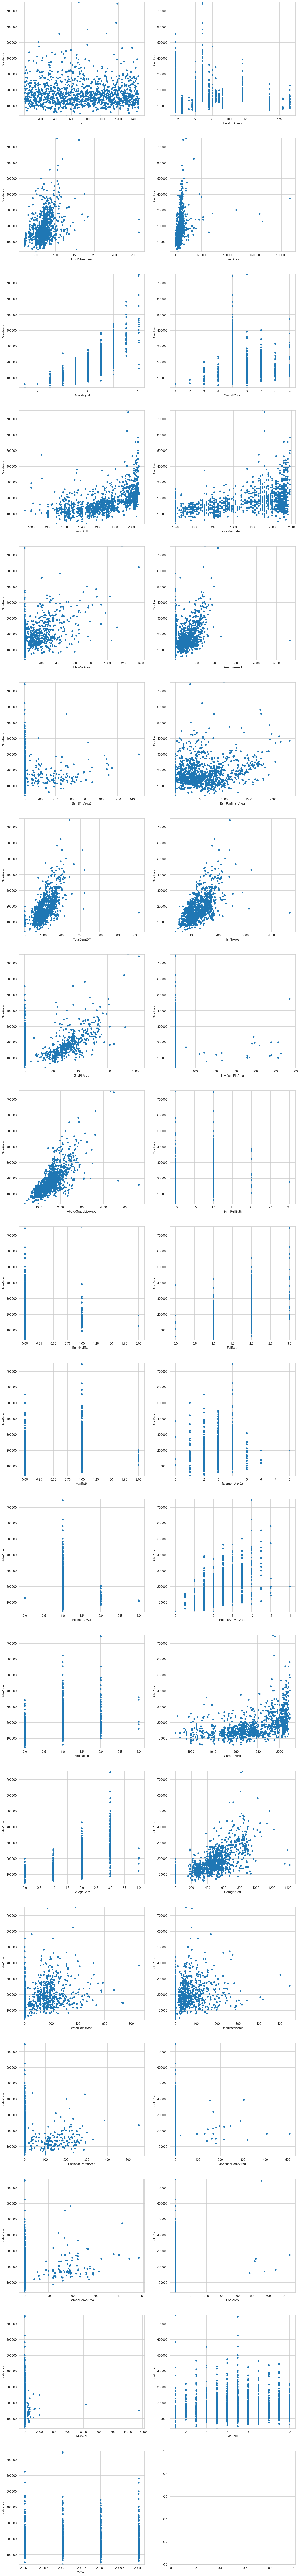

In [155]:
eda.edaContinuous(house, 'SalePrice')

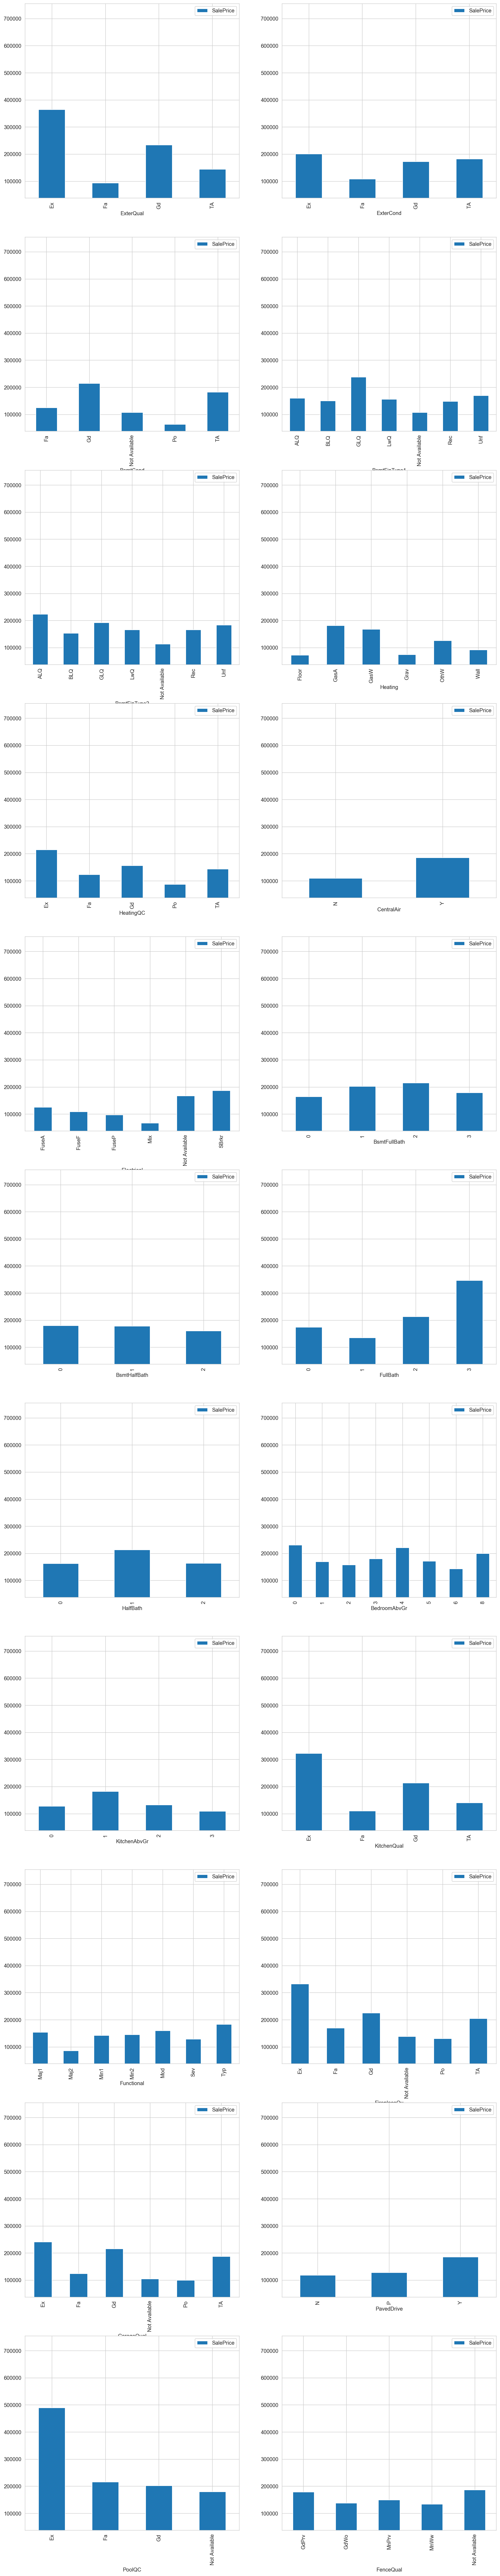

In [156]:
eda.edaCategorical(house[renovateable], 'SalePrice', 'mean')

## Finding any value of changeable property characteristics that can not be explained by the fixed ones.

---

**Objectives:**
1. Finding the effect in dollars of the renovate-able features. 
- How would I use the second model and its coefficients to determine whether a property should be bounght or not? 
- Do I trust my model? Should it be used to evaluate which properties to buy and fix up?

In [157]:
from cLiML import model_prep

df_all = model_prep.dummify(house)

In [158]:
num_cate_var = ['BuildingClass', 'MoSold']

In [159]:
df_all = model_prep.dummify(df_all, categorical_var = num_cate_var)

In [160]:
df_all.drop(columns = ['GarageYrBlt'], inplace = True)

In [161]:
df_test_all = model_prep.dummify_test(house_test)
df_test_all = model_prep.dummify_test(df_test_all, num_cate_var)
df_test_all.drop(columns = ['GarageYrBlt'], inplace = True)
df_test_all = model_prep.match_test_to_train_columns(df_test_all, df_all)

#### scaling

In [162]:
y_all = df_all['SalePrice']
X_all = df_all.drop(columns = ['SalePrice'])


y_test_all = df_test_all['SalePrice']
X_test_all = df_test_all.drop(columns = ['SalePrice'])

In [163]:
from cLiML import model_prep

In [164]:
Xs_all = model_prep.standardize_X_train(X_all)

Xs_test_all = model_prep.standardize_X_test(X_test_all, X_all)

### Performing feature selection

In [165]:
df_feature = model_prep.feature_select_linear_reg(X_all, y_all, cv = 5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [166]:
df_feature

variable_RFECV  support  ranking               variable_skb  \
0        ExteriorCover2_Plywood     True        1                OverallQual   
1              BsmtFinType1_GLQ     True        1         AboveGradeLiveArea   
2    BsmtFinType1_Not Available     True        1                 GarageCars   
3              BsmtFinType1_Rec     True        1                 GarageArea   
4              BsmtFinType2_ALQ     True        1                 1stFlrArea   
5              BsmtFinType2_BLQ     True        1                TotalBsmtSF   
6              BsmtFinType2_GLQ     True        1                   FullBath   
7              BsmtFinType2_LwQ     True        1              BsmtHeight_Ex   
8    BsmtFinType2_Not Available     True        1            RoomsAboveGrade   
9              BsmtFinType2_Rec     True        1                  YearBuilt   
10                Heating_Floor     True        1                 MasVnrArea   
11                 Heating_GasA     True        1               YearRemodAdd   
12                 Heating_GasW     True        1             KitchenQual_Ex   
13                 Heating_Grav     True        1  FireplaceQu_Not Available   
14                 Heating_OthW     True        1           Foundation_PConc   
15                 HeatingQC_Ex     True        1                 Fireplaces   
16                 HeatingQC_Fa     True        1               ExterQual_Gd   
17                 HeatingQC_Gd     True        1               ExterQual_Ex   
18                 HeatingQC_Po     True        1           BsmtFinType1_GLQ   
19                 CentralAir_N     True        1               HeatingQC_Ex   
20             Electrical_FuseA     True        1       Neighborhood_NridgHt   
21             Electrical_FuseP     True        1           GarageFinish_Fin   
22               Electrical_Mix     True        1            MasVnrType_None   
23     Electrical_Not Available     True        1               BsmtFinArea1   
24               KitchenQual_Ex     True        1           BuildingClass_60   
25               KitchenQual_Fa     True        1               SaleType_New   
26               KitchenQual_Gd     True        1          GarageType_Detchd   
27              Functional_Maj1     True        1            FrontStreetFeet   
28              Functional_Maj2     True        1       Neighborhood_NoRidge   
29              Functional_Min1     True        1             FireplaceQu_Gd   
..                          ...      ...      ...                        ...   
245           HouseStyle_1.5Unf     True        1           Utilities_AllPub   
246             BldgType_2fmCon     True        1           BsmtFinType2_GLQ   
247             FrontStreetFeet    False        2                  PoolQC_Gd   
248                ExterQual_Gd    False        3             LowQualFinArea   
249           GarageType_Detchd    False        4               ExterCond_Ex   
250      ExteriorCover1_HdBoard    False        5     ExteriorCover2_AsphShn   
251                  1stFlrArea    False        6                   MoSold_8   
252              FireplaceQu_Gd    False        7                   MoSold_1   
253                  2ndFlrArea    False        8               BsmtHalfBath   
254                YearRemodAdd    False        9           RoofMatl_ClyTile   
255             LandContour_HLS    False       10         GarageType_Basment   
256                  MasVnrArea    False       11               BsmtFinArea2   
257              LowQualFinArea    False       12           RoofMatl_Tar&Grv   
258          AboveGradeLiveArea    False       13               SaleType_CWD   
259            Electrical_FuseF    False       14     ExteriorCover1_Plywood   
260                 TotalBsmtSF    False       15                   MoSold_3   
261            3SeasonPorchArea    False       16           MiscFeature_Gar2   
262             ScreenPorchArea    False       17           LotConfig_Corner   
263              

In [167]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
cv_scores = []
for i in range(1,df_feature['ranking'].max() + 1):
    columns_RFE = df_feature[df_feature['ranking'] <= i]['variable_RFECV'].values.tolist()
    ## performing a simple linear regression
    lr_all = LinearRegression()
    
    cv_scores.append(np.mean(cross_val_score(lr_all, X_all[columns_RFE], y_all, cv = 5)))


print('max score', max(cv_scores))

print('rank', cv_scores.index(max(cv_scores)) + 1)

cv_scores

max score 0.7885432804058597
rank 21


[-2524958065128149.0,
 -1.2641101624310625e+18,
 -2.991432148146223e+17,
 -1.0303184345720572e+16,
 -3.5659310523049683e+17,
 0.786108168693527,
 0.7851172262403423,
 -55252749324121.41,
 -2390379877133199.0,
 -115490489379931.92,
 -232392772748105.75,
 -460278554259242.5,
 -1005315387159864.0,
 -150635326320075.6,
 -185456535413926.47,
 -1658228459104208.8,
 -1115075811650278.2,
 -11472585502615.605,
 -191966385597335.3,
 -1113944690655906.4,
 0.7885432804058597,
 -296534629960984.6,
 -37619929716852.28,
 -807126509397735.2,
 -1651868865532.3345,
 -7464599082223142.0,
 0.7802758783905357,
 0.7799365297363847,
 0.778983968950228]

### Performing Linear regression using features from RFECV

In [168]:
columns_RFE = df_feature[df_feature['ranking'] <= 3]['variable_RFECV'].values.tolist()


In [169]:
X_all.shape

(1221, 275)

In [170]:
X_all.columns.values.tolist()

['Id',
 'FrontStreetFeet',
 'LandArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinArea1',
 'BsmtFinArea2',
 'BsmtUnfinishArea',
 'TotalBsmtSF',
 '1stFlrArea',
 '2ndFlrArea',
 'LowQualFinArea',
 'AboveGradeLiveArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'RoomsAboveGrade',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckArea',
 'OpenPorchArea',
 'EnclosedPorchArea',
 '3SeasonPorchArea',
 'ScreenPorchArea',
 'PoolArea',
 'MiscVal',
 'YrSold',
 'ZoneClassification_RH',
 'ZoneClassification_RL',
 'Street_Grvl',
 'Alley_Grvl',
 'Alley_Not Available',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'Utilities_AllPub',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LandSlope_Gtl',
 'LandSlope_Mod',
 'Neighborhood_Blmngtn',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_Brk

In [171]:
lr = LinearRegression()
predictor_all = lr.fit(X_all[columns_RFE], y_all)
y_test_all_pred = predictor_all.predict(X_test_all[columns_RFE])

In [172]:
predictor_all.score(X_all[columns_RFE], y_all)

0.910158160025129

In [173]:
predictor_all.score(X_test_all[columns_RFE], y_test_all)

0.868636555166567

In [174]:
## checking with cross val
cross_val_score(lr, X_all[columns_RFE], y_all, cv = 5 )

array([-6.72068306e+15,  8.08006261e-01, -5.39408178e+15, -1.48221281e+18,
       -1.38849846e+15])

In [175]:
mean_squared_error(y_test_all_pred, y_test_all)

860771530.7762437

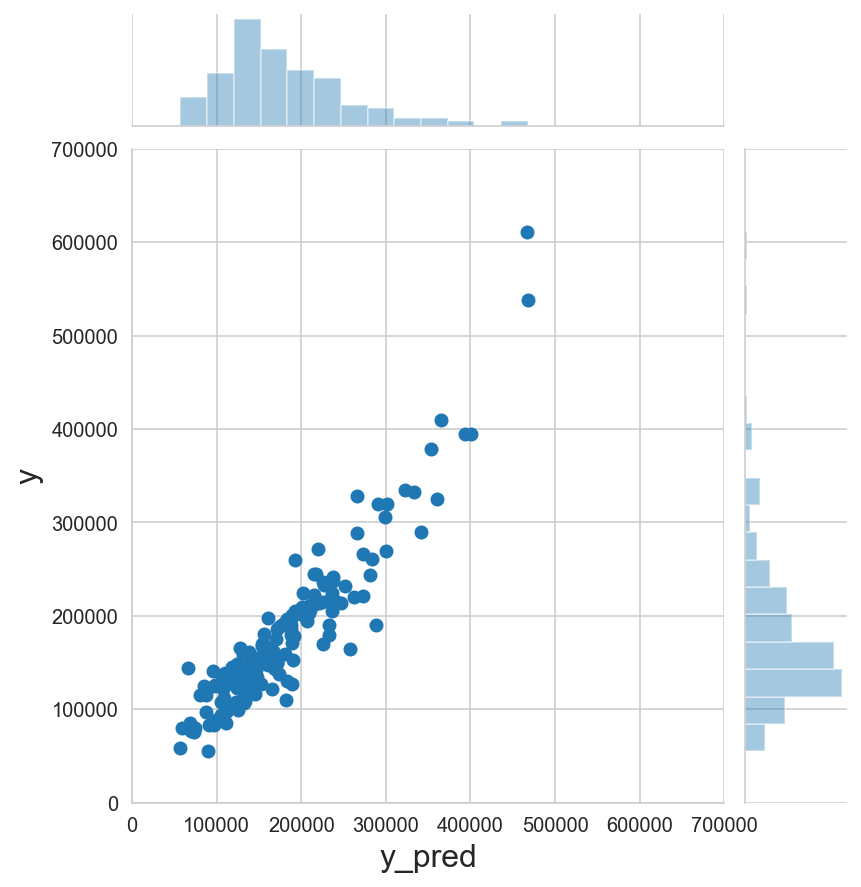

In [176]:
ax = sns.jointplot(x = y_test_all_pred, y = y_test_all, ylim = (0, 700000), xlim = (0,700000), label = 'y_pred')
ax.set_axis_labels('y_pred', 'y', fontsize=16)

In [177]:
## coefficients
var = X_all[columns_RFE].values.tolist()
coef_val = predictor_all.coef_.tolist()
coef_val_abs = abs(predictor_all.coef_).tolist()


In [178]:
len(coef_val)

249

In [179]:
len(columns_RFE)

249

In [180]:
coef_df.head(50).sort_values('variable')

variable   coefficients       coef_abs
28                BedroomAbvGr    8778.821422    8778.821422
25                 BsmtCond_Fa  -10429.139466   10429.139466
39      BsmtCond_Not Available  -22615.396768   22615.396768
40                 BsmtCond_Po   19834.634900   19834.634900
46            BsmtFinType1_BLQ    7303.121483    7303.121483
42            BsmtFinType1_GLQ   15884.886636   15884.886636
43  BsmtFinType1_Not Available  -22615.396768   22615.396768
47            BsmtFinType1_Rec    6142.749683    6142.749683
44            BsmtFinType2_ALQ   27552.752105   27552.752105
41            BsmtFinType2_BLQ  -11556.579695   11556.579695
36            BsmtFinType2_GLQ    6579.908941    6579.908941
23  BsmtFinType2_Not Available   30200.929595   30200.929595
0                 BsmtFullBath   16840.433533   16840.433533
8                 CentralAir_N   -7806.017988    7806.017988
11              Electrical_Mix  -25391.991218   25391.991218
33                ExterCond_Ex   -9255.456429    9255.456429
30                ExterQual_Ex   93639.670418   93639.670418
31                ExterQual_Fa   10464.717366   10464.717366
32                ExterQual_Gd   26328.759914   26328.759914
20              FireplaceQu_Ex   38766.074228   38766.074228
21              FireplaceQu_Fa  -12421.147292   12421.147292
22              FireplaceQu_Gd    8903.828946    8903.828946
38   FireplaceQu_Not Available  -22991.959160   22991.959160
13              FireplaceQu_Po   -7986.145384    7986.145384
26                    FullBath   35693.747048   35693.747048
15             Functional_Maj1  -30643.323329   30643.323329
16             Functional_Maj2  -25505.076569   25505.076569
17             Functional_Min2  -12632.525935   12632.525935
18              Functional_Mod    9824.948701    9824.948701
19              Functional_Sev  -45044.571983   45044.571983
10               GarageQual_Ex   60769.449881   60769.449881
9                GarageQual_Fa  -15952.226624   15952.226624
7                GarageQual_Gd   17321.218991   17321.218991
24    GarageQual_Not Available  -25087.187232   25087.187232
27                    HalfBath   16503.756849   16503.756849
6                 HeatingQC_Ex    7168.045370    7168.045370
45                HeatingQC_Po  -10559.536383   10559.536383
1                Heating_Floor   10200.447627   10200.447627
2                 Heating_GasA   12926.998586   12926.998586
3                 Heating_GasW   29071.465067   29071.465067
4                 Heating_Grav   17538.150141   17538.150141
5                 Heating_OthW   22628.336472   22628.336472
29                KitchenAbvGr  -16985.263076   16985.263076
12              KitchenQual_Ex   67885.811980   67885.811980
14              KitchenQual_Gd   13146.155488   13146.155488
37                PavedDrive_P  -13519.458200   13519.458200
35                   PoolQC_Ex  167058.342495  167058.342495
34                   PoolQC_Gd  -60639.024893   60639.024893

In [181]:
coef_df = pd.DataFrame({'variable': columns_RFE,
                       'coefficients': coef_val,
                       'coef_abs': coef_val_abs}).sort_values('coef_abs', ascending = False)

In [182]:
coef_df[coef_df['variable'].str.contains('RoofMatl')]

variable   coefficients       coef_abs
197  RoofMatl_ClyTile -354605.724558  354605.724558
201     RoofMatl_Roll -120539.947935  120539.947935
202  RoofMatl_Tar&Grv -110781.276544  110781.276544
222  RoofMatl_WdShake  -94143.684270   94143.684270
200    RoofMatl_Metal  -93422.680358   93422.680358
198  RoofMatl_CompShg  -93188.595594   93188.595594
199  RoofMatl_Membran  -89421.201374   89421.201374

### Optimization with grid search

In [183]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
sgd_params = {
    'loss': ['squared_loss'],
    'penalty': ['l2'],
    'alpha': [0.94],
    'l1_ratio': [0.95]
}

sgd_reg = SGDRegressor()
sgd_reg_gs = GridSearchCV(sgd_reg, sgd_params, cv = 5, verbose = False)

In [184]:
sgd_reg_gs.fit(Xs_all[columns_RFE], y_all)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0.001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.94], 'l1_ratio': [0.95],
                         'loss': ['squared_loss'], 'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring

In [185]:
sgd_reg_gs.best_params_

{'alpha': 0.94, 'l1_ratio': 0.95, 'loss': 'squared_loss', 'penalty': 'l2'}

In [186]:
sgd_reg_gs.score(Xs_all[columns_RFE], y_all)

0.8363204723246505

In [187]:
sgd_reg_gs.score(Xs_test_all[columns_RFE], y_test_all)

0.8461647758458639

In [188]:
mean_squared_error(sgd_reg_gs.predict(Xs_test_all[columns_RFE]), y_test_all)

1008020013.104598

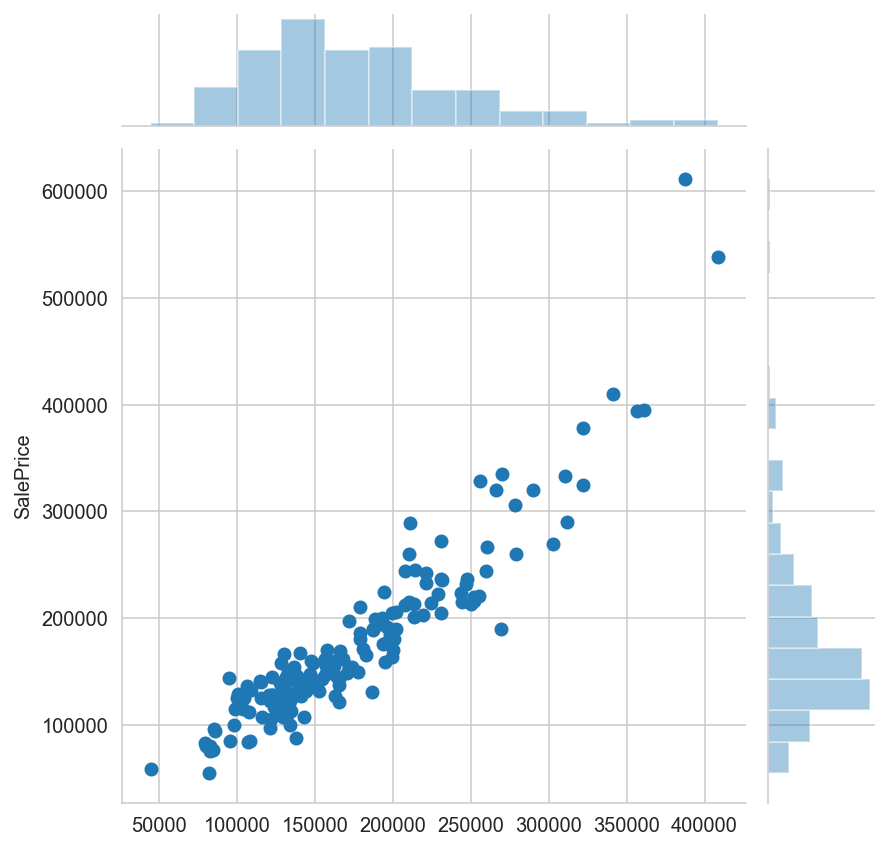

In [189]:
sns.jointplot(x = sgd_reg_gs.predict(Xs_test_all[columns_RFE]), y = y_test_all)

In [190]:
def RSS(y, y_pred):
    import numpy as np
    value = np.square(y - y_pred)
    return np.sum(value)

### Random Forest Regressor

In [191]:
X_all.shape

(1221, 275)

In [192]:
from sklearn.ensemble import RandomForestRegressor
forest_params = {
    'n_estimators': [100],
    'max_depth': [5],
    'max_features': ['auto'],
    'max_leaf_nodes': [70]
}

forest = RandomForestRegressor()
forest_gs = GridSearchCV(forest, forest_params, cv = 10, verbose = False)

In [193]:
forest_gs.fit(X_all[columns_RFE], y_all)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [5], 'max_feature

In [194]:
forest_gs.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': 70,
 'n_estimators': 100}

In [195]:
forest_gs.score(X_all[columns_RFE], y_all)

0.8760295794961637

In [196]:
forest_gs.score(X_test_all[columns_RFE], y_test_all)

0.784721421688008

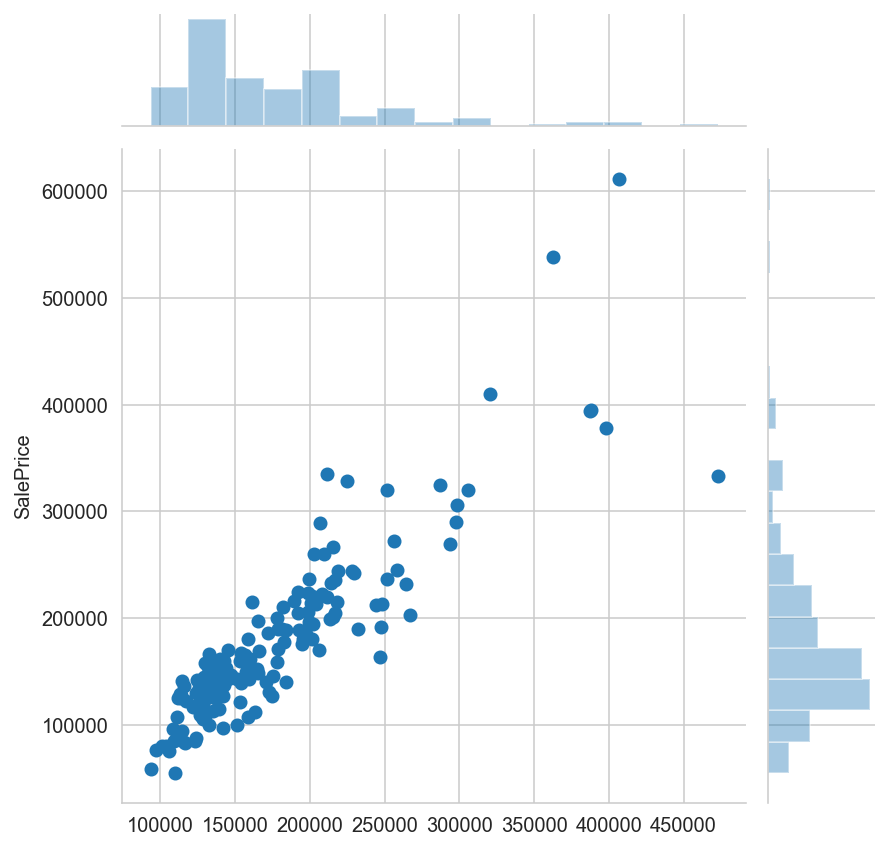

In [197]:
sns.jointplot(x = forest_gs.predict(X_test_all[columns_RFE]), y = y_test_all)